In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import itertools
import random
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
import pickle
import statsmodels.api as sm
import math
import yfinance as yf
from GoogleNews import GoogleNews
from newspaper import Article
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import  LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Activation
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import LeakyReLU
import tensorflow as tf

# Pytorch

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import NHiTS, TimeSeriesDataSet

from pytorch_forecasting.metrics import QuantileLoss, RMSE
from sklego.preprocessing import RepeatingBasisFunction   
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from datetime import datetime
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from tensorflow.keras.callbacks import EarlyStopping #this to keep


# BERT

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch
from transformers import pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


# FUNCTIONS

In [ ]:
def best_feature_selector(df, target_column):

    '''
    Function to that applies
    Select KBest technique to select 
    the features with strongest impact 
    on target variable
    '''

    y = df[target_column]
    x = df.drop(columns = target_column)

    select = SelectKBest(score_func=f_regression, k=10)
    best = select.fit_transform(x, y)

    filter = select.get_support()
    features = np.array(x.columns)
    
    print("Top 10 features:")
    print(features[filter])
    print(best)  

    

def dot_rem(df, column):

    '''
    Function to remove 
    special characters
    from string
    '''

    subs = df[column] == "."
    df.loc[subs, column] = np.nan
    df[column] = df[column].astype('float')

    return df

def log_ret(df, column, index):

    '''
    Function to calculate 
    log returns
    '''

    df[f'Return_{index}'] = np.log(df[column]) - np.log(df[column].shift(1))
    df.dropna(inplace=True)
    df.drop(columns=column, inplace=True)

    return df


def y_data_downloader(tick, start_date, end_date, tickname):

    '''
    Function to download data from
    YFinance
    '''

    y_df = yf.download(tick, start=start_date, end=end_date)
    y_df.reset_index(inplace=True)
    y_df.Date = pd.to_datetime(y_df.Date, format='%Y%m%d')
    y_df['Date'] = y_df['Date'].dt.tz_localize(None) 
    y_df = y_df[['Date', 'Close']]
    y_df['Close'] = y_df['Close'].shift(-1)
    log_ret(y_df, 'Close', tickname)

    return y_df



def sentiment_analyzier(df):

    '''
    
    '''

    lis =[]
    for ind in df.index:
        dict={}
        try:
            article = Article(df['link'][ind])
            article.download()
            article.parse()
            article.nlp()
        except:
            pass
    
        dict['Date']=df['date'][ind]
        dict['Media']=df['media'][ind]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        lis.append(dict)

    news_df=pd.DataFrame(lis)

    nlp_all = pd.DataFrame()
    for i, c in zip(news_df['Summary'], news_df['Date']):

        analyzer = SentimentIntensityAnalyzer().polarity_scores(i)

        neg = analyzer['neg']
        pos = analyzer['pos']
        neu = analyzer['neu']
        comp = analyzer['compound']

        nlp_all = nlp_all.append({'Date':c,'Text':i, 'Negative_sent':neg, 'Positive_sent':pos, 'Neutral_sent':neu, 'Compounded':comp}, ignore_index=True)

    correct_m = {
        'an':'Jan',
        'eb':'Feb',
        'ar':'Mar', 
        'pr':'Apr',
        'ay':'May',
        'un':'Jun',
        'ul':'Jul', 
        'ug':'Aug', 
        'ep':'Sep',
        'ct':'Oct',
        'ov':'Nov',
        'ec':'Dec'
    }

    correct_m_2 = {
        'SS':'S',
        'DD':'D',
        'AA':'A',
        'NN':'N',
        'MM':'M',
        'JJ':'J',
        'FF':'F'
    }

    for char in correct_m.keys():
        
        nlp_all.Date = nlp_all.Date.str.replace(char, correct_m[char])

    for char in correct_m_2.keys():
        
        nlp_all.Date = nlp_all.Date.str.replace(char, correct_m_2[char]) 

    nlp_all = nlp_all[nlp_all.Date!='2 weeks ago']

    nlp_all['splt'] = nlp_all.Date.str.split(' ').str[0]
    nlp_all['splt'] = nlp_all['splt'].apply(lambda x: x[1:] if len(x)>3 else x)
    nlp_all['Date1'] = nlp_all['Date'].str.split().str[1:].str.join('')

    nlp_all['Date'] = nlp_all['splt'] + ' ' + nlp_all['Date1']
    nlp_all.Date = pd.to_datetime(nlp_all.Date, format='%b %d,%Y')

    nlp_all = nlp_all[['Negative_sent', 'Positive_sent', 'Neutral_sent', 'Compounded', 'Date']]
    nlp_all.Date = pd.to_datetime(nlp_all.Date)

    nlp_all['Week'] = nlp_all.Date.dt.weekofyear
    nlp_all['Year'] = nlp_all.Date.dt.year
    nlp_all = nlp_all.groupby(['Week', 'Year']).agg({'Negative_sent':'sum', 'Positive_sent':'sum', 'Neutral_sent':'sum', 'Compounded':'sum'}).reset_index()


    return nlp_all


def pq_arima_finder(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


def plot_rmse(model):

  '''
  Function to plot RMSE
  '''
  
  fig = plt.figure(figsize=(20,7))
  fig.add_subplot(121)
  plt.plot(model.epoch, model.history['root_mean_squared_error'], label = "rmse")
  plt.plot(model.epoch, model.history['val_root_mean_squared_error'], label = "val_rmse")

  plt.title("RMSE", fontsize=18)
  plt.xlabel("Epochs", fontsize=15)
  plt.ylabel("RMSE", fontsize=15)
  plt.grid(alpha=0.3)
  plt.legend()

  fig.add_subplot(122)

  plt.plot(model.epoch, model.history['loss'], label="loss")
  plt.plot(model.epoch, model.history['val_loss'], label="val_loss")

  plt.title("Loss", fontsize=18)
  plt.xlabel("Epochs", fontsize=15)
  plt.ylabel("Loss", fontsize=15)
  plt.grid(alpha=0.3)
  plt.legend()

  plt.show()


def compare_plot(original_df, predictions_df, color_real, color_pred):

  '''
  Function to plot predictions 
  and to compare them with real returns
  '''

  plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
  plt.grid(True)

  plt.plot(original_df, color=color_real, label='Real Returns of Oil Futures Contract')
  plt.plot(predictions_df, color=color_pred, label='Prediction of Returns of Oil Futures Contract')
  #plt.axvline(x = x, color = 'b', label = 'axvline - full height')

  plt.legend(loc='best')


def return_prediction(X_test,y_test, X_train,y_train , full_df, model, name, how):

  '''
  Function to create predictions based on trained models
  '''

  if how=='price':

    y_pred = model.predict(X_test)

    y_pred_train = model.predict(X_train)

    predictions_inversed = np.repeat(y_pred, full_df.shape[1], axis=-1)
    predictions = sc.inverse_transform(predictions_inversed)[:,0]

    train_inversed = np.repeat(y_pred_train, full_df.shape[1], axis=-1)
    train_pred = sc.inverse_transform(train_inversed)[:,0]

    train_inversed_real = np.repeat(y_train, full_df.shape[1], axis=-1)
    train_real = sc.inverse_transform(train_inversed_real)[:,0]

    real_inversed = np.repeat(y_test, full_df.shape[1], axis=-1)
    real = sc.inverse_transform(real_inversed)[:,0]

    compare_df = pd.DataFrame({'Real_value':real, 'Predicted_value':predictions})
    compare_df_train = pd.DataFrame({'Real_value':train_real, 'Predicted_value':train_pred})

    # ####ONE BIG PLOT
    # compare_df1 = pd.concat([ compare_df_train, compare_df], axis=0)
    # compare_df1 = compare_df1.reset_index(drop=True)

    ####END

    compare_plot(compare_df.Real_value, compare_df.Predicted_value, 'orange', 'grey')
    compare_plot(compare_df_train.Real_value, compare_df_train.Predicted_value, 'green', 'grey')
    compare_df.dropna(inplace=True)
    compare_df.to_csv(f'predictions_{name}.csv')
  
  if how=='return':

    y_pred = model.predict(X_test)

    y_pred_train = model.predict(X_train)

    predictions_inversed = np.repeat(y_pred, full_df.shape[1], axis=-1)
    predictions = sc.inverse_transform(predictions_inversed)[:,0]

    train_inversed = np.repeat(y_pred_train, full_df.shape[1], axis=-1)
    train_pred = sc.inverse_transform(train_inversed)[:,0]

    train_inversed_real = np.repeat(y_train, full_df.shape[1], axis=-1)
    train_real = sc.inverse_transform(train_inversed_real)[:,0]

    real_inversed = np.repeat(y_test, full_df.shape[1], axis=-1)
    real = sc.inverse_transform(real_inversed)[:,0]

    compare_df = pd.DataFrame({'Real_value':real, 'Predicted_value':predictions})
    compare_df = compare_df.reset_index(drop=True)
    compare_df['Real_value'] = np.log(compare_df['Real_value']).diff()
    compare_df['Predicted_value'] = np.log(compare_df['Predicted_value']).diff()

    compare_df_train = pd.DataFrame({'Real_value':train_real, 'Predicted_value':train_pred})
    compare_df_train = compare_df_train.reset_index()
    compare_df_train['Real_value'] = np.log(compare_df_train['Real_value']).diff()
    compare_df_train['Predicted_value'] = np.log(compare_df_train['Predicted_value']).diff()

    ####ONE BIG PLOT
    # compare_df1 = pd.concat([ compare_df_train, compare_df], axis=0)
    # compare_df1 = compare_df1.reset_index(drop=True)

    ####END

    compare_plot(compare_df.Real_value, compare_df.Predicted_value ,'orange', 'grey')

    compare_plot(compare_df_train.Real_value, compare_df_train.Predicted_value, 'green', 'grey')

    #compare_df = compare_df.reset_index(drop=True).dropna()
    compare_df.dropna(inplace=True)
    
    compare_df.to_csv(f'predictions_{name}.csv')

  
  return compare_df


def create_data_train(df, n_future, n_past):
  
  '''
  Function to create rolling windows
  for training data
  
  '''

  n_feature = df.shape[1]
  x_train, y_train = [], []
  
  for i in range(n_past, len(df) - n_future + 1):
    x_train.append(df[i - n_past:i, 0:n_feature])
    y_train.append(df[i + n_future - 1:i + n_future, 0]) 
  
  return np.array(x_train), np.array(y_train)


def create_data_test(df, n_future, n_past):

  '''
  Function to create rolling windows 
  for testing data
  '''

  n_feature = df.shape[1]
  x_test, y_test = [], []
  
  for i in range(n_past, len(df) - n_future + 1):

    x_test.append(df[i - n_past:i, 0:n_feature])
    y_test.append(df[i + n_future - 1:i + n_future, 0])
  
  return np.array(x_test), np.array(y_test)


def build_model_lstm_univariate(hp):

  ''''
  Function to optimize the lstm model
  '''

  model = Sequential()

  model.add(LSTM(hp.Int('input_unit' ,min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_uni.shape[1],X_train_uni.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 4)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=256, step=32), return_sequences=True, input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


def build_model_cnn_univariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=512,
                              step=32),kernel_size= hp.Int(name="kernel_0", min_value=5, max_value=7, step=2), input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=1))

  for i in range(hp.Int('n_layers', 1, 5)):

    model.add(Conv1D(hp.Int(f'conv_{i}_units',
                            min_value=32,
                            max_value=256,
                            step=32, kernel_size=2)))
    model.add(Activation('relu'))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


def build_model_lstm_multivarite(hp):

  '''
  Function to optimize multivariate LSTM model
  '''


  model = Sequential()

  model.add(LSTM(hp.Int('input_unit' ,min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_mv.shape[1],X_train_mv.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 4)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_mv.shape[1], X_train_mv.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


def build_model_cnn_multivariate(hp): 

  '''
  Function to optimize multivariate CNN model
  '''

  model = keras.models.Sequential()

  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=512,
                              step=32),kernel_size= hp.Int(name="kernel_0", min_value=5, max_value=7, step=2), input_shape=(X_train_uni.shape[1], X_train_uni.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=1))

  for i in range(hp.Int('n_layers', 1, 5)):
        
    model.add(Conv1D(hp.Int(f'conv_{i}_units',
                            min_value=32,
                            max_value=512,
                            step=32), kernel_size= 1))
    model.add(Activation('relu'))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


def split_data(df, test_size):

  '''Function to split the data'''

  train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
  
  return train, test
  

def save_rmse():

  lstm_univariate_list = []
  train_rmse = lstm_univariate.evaluate(X_train_univariate, y_train_univariate)[1]
  test_rmse = lstm_univariate.evaluate(X_test_univariate, y_test_univariate)[1]
  lstm_univariate_list.extend([train_rmse,test_rmse])

  lstm_multivariate_list = []
  train_rmse = lstm_multivariate.evaluate(X_train_multivariate, y_train_multivariate)[1]
  test_rmse = lstm_multivariate.evaluate(X_test_multivariate, y_test_multivariate)[1]
  lstm_multivariate_list.extend([train_rmse,test_rmse])

  cnn_univariate_list = []
  train_rmse = cnn_univariate.evaluate(X_train_univariate, y_train_univariate)[1]
  test_rmse = cnn_univariate.evaluate(X_test_univariate, y_test_univariate)[1]
  cnn_univariate_list.extend([train_rmse,test_rmse])

  cnn_multivariate_list = []
  train_rmse = cnn_multivariate.evaluate(X_train_multivariate, y_train_multivariate)[1]
  test_rmse = cnn_multivariate.evaluate(X_test_multivariate, y_test_multivariate)[1]
  cnn_multivariate_list.extend([train_rmse,test_rmse])


  results = pd.DataFrame(columns=['Indicator','LSTM_univariate','LSTM_multivariate',
                                  'CNN_univariate', 'CNN_multivariate', 'Date'])
  results['Indicator'] = pd.Series(['RMSE_train', 'RMSE_test'])
  results['LSTM_univariate'] = pd.Series(lstm_univariate_list)
  results['LSTM_multivariate'] = pd.Series(lstm_multivariate_list)
  results['CNN_univariate'] = pd.Series(cnn_univariate_list)
  results['CNN_multivariate'] = pd.Series(cnn_multivariate_list)
  results['Date'] = pd.to_datetime(datetime.now())

  return results


def evaluate_inv_strategy(preds, real_col, pred_col, specificator):

  if specificator=='returns':

    preds['real_returns'] = preds['Real_value'].shift(-1)
    preds['preds_returns'] = preds['Predicted_value'].shift(-1)

    preds['signal_preds'] = np.where(preds[pred_col].shift(-1) > preds[pred_col], 1, -1)
    preds['signal_real'] = np.where(preds[real_col].shift(-1) > preds[real_col], 1, -1)
    preds['strat_return'] = preds.signal_preds.shift(1) * preds.real_returns#preds.signal_preds.shift(1) * preds['preds_returns']
    preds.dropna(inplace=True)

    preds['Cumul_real'] = preds.real_returns.cumsum()
    preds['Cumul_strat'] = preds.strat_return.cumsum()

  if specificator=='prices':

    preds['real_returns'] = np.log(preds[real_col]).diff()#.shift(-1) # posuniti abych si vypocital vcerejsi vynos
    preds['preds_returns'] = np.log(preds[pred_col]).diff()#.shift(-1)
  

    preds['signal_preds'] = np.where(preds[pred_col].shift(-1)>preds[pred_col], 1, -1) # cena ropy,
    preds['signal_real'] = np.where(preds[real_col].shift(-1)>preds[real_col], 1, -1)

    preds['strat_return'] = preds.signal_preds.shift(1) * preds.real_returns #preds.signal_preds.shift(1) * preds['preds_returns']
    preds.dropna(inplace=True)

    preds['Cumul_real'] = preds.real_returns.cumsum()
    preds['Cumul_strat'] = preds.strat_return.cumsum()

  return preds


def sharpe_ratio(df, returns, days,  rf ):

    df['sharpe'] = df[returns].mean() / df[returns].std()
    df['sharpe_annualized'] = df['sharpe']*days*rf

    return df

def sortino_ratio(df, returns, days , rf):

    df['sortino'] = df[returns].mean() / df[(df[returns]<0)][returns].std()
    df['sortino_annualized'] = df['sortino']*days*rf

    return df


def drawdown_ratio(df, returns):

    drawdown = (df[returns] + 1).cumprod()
    peak = drawdown.expanding(min_periods=1).max()
    df['drawdown'] = ((drawdown/peak)-1).min()
    
    return df

def prepare_ff_regression(df, regresion_df, test_df, rf):

    df = df[['strat_return', 'real_returns']]

    df['Date'] = test_df['Date']

    test_df['Date'] = pd.to_datetime(test_df['Date'])
    regresion_df['Date'] = pd.to_datetime(regresion_df['Date'])

    df_exogen = pd.merge(test_df[['Date']], regresion_df, on='Date', how='left')

    df_exogen = pd.merge(df_exogen, df, on='Date', how='left')

    df_exogen.dropna(inplace=True)

    df_exogen['real_returns'] = df_exogen['real_returns'] - rf

    return df_exogen



def calculate_ff_regression(df, column_endogenious, list_exogenious):

    y = df[[column_endogenious]]
    
    X = df[list_exogenious]

    X_sm = sm.add_constant(X)

    model = sm.OLS(y, X_sm)

    results = model.fit() 
  
    return results.summary()

    

  



# Constants

In [ ]:
# Variables
TEST_SIZE = 511
VALIDATION_SPLIT = 0.1
EPOCHS = 10
BATCH_SIZE = 128
PATIENCE = 20
FUTURE_SIZE = 1
WINDOW_SIZE = 5

# ARIMA

In [ ]:
#temporary
df_arima = pd.read_parquet('oil_best_feats_v3.parquet')
df_arima.set_index('Date', inplace=True)

df_arima = df_arima[['c1']]

df_arima['c1'] = np.log(df_arima.c1) - np.log(df_arima.c1.shift(1))
df_arima.dropna(inplace=True)


ad_fuller_result = adfuller(df_arima['c1'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


train = df_arima[:-504]
test = df_arima[-504:]

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 0

order_list = list(product(ps, qs))

result_arima = pq_arima_finder(train, order_list, d)
result_arima

model = SARIMAX(train, order=(0,0,0), simple_differencing=True)
model_fit = model.fit(disp=False)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10,8))

ARIMA_pred = model_fit.get_prediction(len(train),len(df_arima)).predicted_mean
pred = pd.DataFrame(ARIMA_pred)
pred.reset_index(drop=True, inplace=True)
test.reset_index(inplace=True)
test = test.join(pred.predicted_mean)


# report performance
mse = mean_squared_error(test.c1, test.predicted_mean)
print('MSE: '+str(mse))
mae = mean_absolute_error(test.c1, test.predicted_mean)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test.c1, test.predicted_mean))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test.predicted_mean - test.c1)/np.abs(test.c1))
print('MAPE: '+str(mape))


# Feature Engineering

In [8]:
df = pd.read_excel("wti_data.xlsx", sheet_name='Close',parse_dates=['Date'])
dates = pd.read_excel("wti_data.xlsx", sheet_name='Maturities', parse_dates = ['NCL_LTD'])
ncl = pd.read_excel("wti_data.xlsx", sheet_name='LTD_ID', parse_dates = ['Date'])
volume = pd.read_excel("wti_data.xlsx", sheet_name='Volume', parse_dates=['Date'])
open = pd.read_excel("wti_data.xlsx", sheet_name='Open', parse_dates=['Date'])
high = pd.read_excel("wti_data.xlsx", sheet_name='High', parse_dates=['Date'])
close = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
low = pd.read_excel("wti_data.xlsx", sheet_name='Low', parse_dates=['Date'])



df.rename(columns={df.columns[1]: 'c1', df.columns[2]:'c2'}, inplace=True)
df = df[['Date','c1', 'c2']]
df['Spread'] = df['c1']-df['c2']
df['Spread'] = df['Spread'].shift(-1)
df = pd.merge(df, dates, left_on='Date', right_on='NCL_LTD', how='left')
df.drop(columns='Contract', inplace=True)
df['NCL_LTD'] = np.where(df['NCL_LTD'].notna(), 1, 0)
df['Shift'] = df['NCL_LTD'].shift(-1)
df.loc[df['Shift']==1, ['c1']] = df['c2']
df['Shift'].fillna(0, inplace=True)
df.drop(columns=['c2'], inplace=True)



# TIME FEATURES
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Quarter'] = df.Date.dt.quarter
df['Day'] = df.Date.dt.day_of_week
df['Week'] = df.Date.dt.weekofyear



# MARKET YIELDS
my_1 = pd.read_csv('my_us_1y.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
my_10 = pd.read_csv('my_us_10y.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})

dot_rem(my_1, 'DGS1')
dot_rem(my_10, 'DGS10')

my_1['DGS1'] = my_1['DGS1'].shift(-1)
my_10['DGS10'] = my_10['DGS10'].shift(-1)

df = pd.merge(df, my_1, on='Date', how='left')
df = pd.merge(df, my_10, on='Date', how='left')


# VIX 
vix = pd.read_csv('vix.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
dot_rem(vix, 'VIXCLS')
vix['VIXCLS'] = vix['VIXCLS'].shift(-1)
df = pd.merge(df, vix, on='Date', how='left')


#OIL INVENTORIES
oi = pd.read_csv('oil_inventories_investing.csv', parse_dates=['Release Date']).rename(columns={'Release Date':'Date', 'Actual':'Inventories'})
oi.Date = oi.Date.str.replace(r"\(.*\)","")
oi.Inventories = oi.Inventories.str.replace('(M)', '', regex=True)
oi.Date = pd.to_datetime(oi.Date)
oi.Inventories = oi.Inventories.astype('float')
oi.Inventories = oi.Inventories*1000000
oi = oi[['Date', 'Inventories']]

oi_2008 = oi[oi.Date<='2008-01-01']
oi_2008.index = pd.to_datetime(oi_2008.Date)
oi_2008 = oi_2008.shift(-1, freq = "M")
oi_2008.drop(columns='Date', inplace=True)
oi_2008.reset_index(inplace=True)
oi_2008['Year'] = oi_2008['Date'].dt.year
oi_2008['Month'] = oi_2008['Date'].dt.month
oi_2008.drop(columns='Date', inplace=True)
oi_2008['Inventories'] = oi_2008['Inventories'].shift(-1)

df = pd.merge(df, oi_2008, on=['Month', 'Year'], how='left')

oi_22 = oi[oi.Date>'2008-01-01']
oi_22['Year'] = oi_22['Date'].dt.year
oi_22['Week'] = oi_22['Date'].dt.weekofyear
oi_22.drop(columns='Date', inplace=True)
oi_22['Inventories'] = oi_22['Inventories'].shift(-1)

df = pd.merge(df, oi_22, on=['Week', 'Year'], how='left')
df.Inventories_x.fillna(0, inplace=True)  
df.Inventories_y.fillna(0, inplace=True)  
df['Inventories']=df['Inventories_x'] + df['Inventories_y']

df.drop(columns=['Inventories_x','Inventories_y'], inplace=True)
df.drop_duplicates(subset=['Date'], inplace=True)


#RIG COUNT
rig = pd.read_csv('rig.csv', parse_dates=['Release Date']).rename(columns={'Release Date':'Date', 'Actual':'Rig_actual'})
rig = rig[['Date', 'Rig_actual']].dropna()
rig['Week'] = rig['Date'].dt.weekofyear
rig['Month'] = rig['Date'].dt.month
rig['Year'] = rig['Date'].dt.year
rig.drop(columns='Date', inplace=True)
rig['Rig_actual'] = rig['Rig_actual'].shift(-1)

df = pd.merge(df, rig, on=['Week', 'Month', 'Year'], how='left')
df.drop_duplicates(subset=['Date'], inplace=True)


# US PRODUCTION
us_prod = pd.read_csv('us_ind_prod.csv').rename(columns={'Release Date':'Date', 'Actual':'Prod_actual'})
us_prod.Date = us_prod.Date.str.replace(r"\(.*\)","")
us_prod.Prod_actual = us_prod.Prod_actual.str.replace('(%)', '', regex=True).astype('float')
us_prod.Date = pd.to_datetime(us_prod.Date)
us_prod = us_prod[['Date', 'Prod_actual']]
us_prod['Month'] = us_prod['Date'].dt.month
us_prod['Year'] = us_prod['Date'].dt.year
us_prod.drop(columns='Date', inplace=True)
us_prod.dropna(inplace=True)
us_prod['Prod_actual'] = us_prod['Prod_actual'].shift(-1)

df = pd.merge(df, us_prod, on=['Month', 'Year'], how='left')


#GDP
us_gdp = pd.read_csv('gdp_us.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
us_gdp['Quarter'] = us_gdp.Date.dt.quarter
us_gdp['Year'] = us_gdp.Date.dt.year
us_gdp.drop(columns='Date', inplace=True)
us_gdp['GDP'] = us_gdp['GDP'].shift(-1)

df = pd.merge(df, us_gdp, on=['Quarter', 'Year'], how='left')


#CPI
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['DATE']).rename(columns={'DATE':'Date'})
cpi['Month'] = cpi.Date.dt.month
cpi['Year'] = cpi.Date.dt.year
cpi.drop(columns='Date', inplace=True)
cpi['CPIAUCSL'] = cpi['CPIAUCSL'].shift(-1)

df = pd.merge(df, cpi, on=['Month', 'Year'], how='left')


# S&P
sp = y_data_downloader("^GSPC", "1983-01-01", "2023-03-01", "sp")
df = pd.merge(df, sp, on='Date', how='left')


# NASDAQ
ns = y_data_downloader("^IXIC", "1983-01-01", "2023-03-01", "nasdaq")
df = pd.merge(df, ns, on='Date', how='left')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
df.fillna(0, inplace=True)

# Sentiment Analysis

# BERT

In [10]:
finbert =  AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [13]:
tokenizer

BertTokenizer(name_or_path='yiyanghkust/finbert-tone', vocab_size=30873, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [11]:
finbert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# Download the news
nlp = pd.read_csv('nlp_opec_10_22.csv')
lis =[]
for ind in nlp.index:
    dict={}
    try:
      
      article = Article(nlp['link'][ind])
      article.download()
      article.parse()
      article.nlp()

    except:
      
      pass
  
    dict['Date']=nlp['date'][ind]
    dict['Media']=nlp['media'][ind]
    dict['Title']=article.title
    dict['Article']=article.text
    dict['Summary']=article.summary
    dict['Key_words']=article.keywords
    lis.append(dict)

news_df=pd.DataFrame(lis)



In [14]:
def remove_alphanumeric_chars(df, column_to_clean, new_column):
    '''
    Function to remove 
    alphnumeric characters
    '''
    df[new_column] = df[column_to_clean].str.replace('[^A-Za-z0-9]+', ' ')
    df[new_column] = df[new_column].str.lower()

    return df


def fin_sentiment_analyzer_bert(text):

    token = tokenizer.encode(text, return_tensors='pt')
    sentiment = finbert(token)
    score = int(torch.argmax(sentiment.logits))+1

    return score


news_df = remove_alphanumeric_chars(news_df, 'Article', 'Summary_cleaned')
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

news_df['Sentiment'] = news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512]))
news_df['Fin_Score'] = news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512])[0]['score'])
news_df['Sentiment_label'] = news_df['Summary_cleaned'].apply(lambda x: nlp(x[:512])[0]['label'])

In [16]:
news_df.to_csv('nlp_dp.csv')

In [17]:
pd.set_option('display.width', 1000)

In [243]:
correct_m = {

        'an':'Jan',
        'eb':'Feb',
        'ar':'Mar', 
        'pr':'Apr',
        'ay':'May',
        'un':'Jun',
        'ul':'Jul', 
        'ug':'Aug', 
        'ep':'Sep',
        'ct':'Oct',
        'ov':'Nov',
        'ec':'Dec'
    }

correct_m_2 = {

    'SS':'S',
    'DD':'D',
    'AA':'A',
    'NN':'N',
    'MM':'M',
    'JJ':'J',
    'FF':'F'
}

for char in correct_m.keys():
    
    news_df.Date = news_df.Date.str.replace(char, correct_m[char])


for char in correct_m_2.keys():
    
    news_df.Date = news_df.Date.str.replace(char, correct_m_2[char]) 

news_df = news_df[['Date', 'Fin_Score', 'Sentiment_label']]
news_df = news_df[news_df.Date!='2 weeks ago']

news_df['splt'] = news_df.Date.str.split(' ').str[0]
news_df['splt'] = news_df['splt'].apply(lambda x: x[1:] if len(x)>3 else x)
news_df['Date1'] = news_df['Date'].str.split().str[1:].str.join('')

news_df['Date'] = news_df['splt'] + ' ' + news_df['Date1']
news_df.Date = pd.to_datetime(news_df.Date, format='%b %d,%Y')


news_df.Date = pd.to_datetime(news_df.Date)

news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Negative'), 0, news_df['Sentiment_label'])
news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Neutral'), 1, news_df['Sentiment_label'])
news_df['Sentiment_label'] = np.where((news_df['Sentiment_label']=='Positive'), 2, news_df['Sentiment_label'])


news_df['Week'] = news_df.Date.dt.weekofyear
news_df['Year'] = news_df.Date.dt.year
news_df = news_df.groupby(['Week', 'Year']).agg({'Fin_Score':'max', 'Sentiment_label':'max'}).reset_index()

In [251]:
news_df.head()

,Week,Year,Fin_Score,Sentiment_label
0,1,2007,0.999664,1
1,1,2008,0.999895,0
2,1,2009,0.997685,1
3,1,2010,0.998911,1
4,1,2011,0.999921,1


In [275]:
# MERGE TO MAIN DF
df = pd.merge(df, news_df, on=['Week', 'Year'], how='left')
df['Sentiment_present'] = np.where((df['Sentiment_label']==0), 0, 1)

# GOOGLE TRENDS

In [276]:
trends = pd.read_csv('trends_opec.csv')
trends.Date = pd.to_datetime(trends.Date)
trends['Week'] = trends.Date.dt.weekofyear
trends['Year'] = trends.Date.dt.year
trends.drop(columns='Date', inplace=True)
trends.drop_duplicates(inplace=True)
df = pd.merge(df, trends, on=['Week', 'Year'], how='left')

In [277]:
df.fillna(0, inplace=True)

In [279]:
df.to_parquet('oil_best_feats_v3.parquet')

# Select the best features

In [ ]:
best_feature_selector(df, 'c1')

# Create windows

In [703]:
from keras.callbacks import EarlyStopping

In [19]:
# df_multivariate = pd.read_csv('oil_best_feats_v2.csv')
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate.set_index('Date', inplace=True)

# Create univariate df
df_univariate = df_multivariate[['c1']]
df_univariate['c1'] = np.log(df_univariate.c1) - np.log(df_univariate.c1.shift(1))
df_univariate.dropna(inplace=True)
df_univariate = np.asarray(df_univariate)

# create univariate windows
train_univariate, test_univariate = df_univariate[:-TEST_SIZE], df_univariate[-TEST_SIZE:]
X_train_univariate, y_train_univariate = create_data_train(train_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)
X_test_univariate, y_test_univariate = create_data_test(test_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)

In [28]:
df_univariate = df_multivariate[['c1']]
df_univariate['c1'] = np.log(df_univariate.c1) - np.log(df_univariate.c1.shift(1))
df_univariate.dropna(inplace=True)
df_univariate['Benchmark'] = 0
df_univariate = df_univariate[-504:]
math.sqrt(mean_squared_error(df_univariate.c1, df_univariate.Benchmark))

0.02656367376312381

In [29]:
df_univariate.head()

,c1,Benchmark
Date,,
2021-02-25,0.004892,0
2021-02-26,-0.032475,0
2021-03-01,-0.014082,0
2021-03-02,-0.014786,0
2021-03-03,0.025284,0


In [ ]:
df_multivariate[df_multivariate.Fin_Score != 0]

# LSTM Univariate Time Series Modelling

In [ ]:
# Tuning the hyperparameters of the network

def build_model_lstm_univariate(hp):

  ''''
  Function to optimize the lstm model
  '''
  
  model = Sequential()

  # model.add(LSTM(hp.Int('input_unit' ,min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 1)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


tuner_lstm_univariate = RandomSearch(
        build_model_lstm_univariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
        )

tuner_lstm_univariate.search(
        x=X_train_univariate,
        y=y_train_univariate,
        epochs=100,
        batch_size=128,
        
)

best_model_lstm_univariate = tuner_lstm_univariate.get_best_models(num_models=1)[0]
tuner_lstm_univariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_lstm_univariate.get_best_hyperparameters()[0].values

best_model_lstm_univariate.summary()





In [ ]:
tuner_lstm_univariate.get_best_hyperparameters()[0].values

In [702]:
# tf.random.set_seed(1234)
lstm_univariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=PATIENCE, 
                                    mode='min')
# tf.keras.layers.LeakyReLU(alpha=0.1)
lstm_univariate.add(LSTM(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2]), 
                              return_sequences=False))

# lstm_univariate.add(LSTM(80, activation='relu', input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2]), 
#                               return_sequences=False))


lstm_univariate.add(Dropout(0.01))
lstm_univariate.add(Dense(y_train_univariate.shape[1], activation='tanh'))

optimizer = keras.optimizers.Adam(learning_rate=0.01)

lstm_univariate.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_lstm_un = lstm_univariate.fit(X_train_univariate ,y_train_univariate,validation_split=VALIDATION_SPLIT ,
                               epochs=100, batch_size=128,
                               callbacks=[early_stopping])

lstm_univariate.evaluate(X_test_univariate, y_test_univariate)
lstm_univariate.evaluate(X_train_univariate, y_train_univariate)

AttributeError: 'EarlyStopping' object has no attribute 'set_model'

In [305]:
lstm_univariate.evaluate(X_test_univariate, y_test_univariate)

16/16 [==============================] - 0s 10ms/step - loss: 7.1856e-04 - root_mean_squared_error: 0.0268


[0.0007185641443356872, 0.026806047186255455]

In [306]:
lstm_univariate.evaluate(X_train_univariate, y_train_univariate)

310/310 [==============================] - 3s 11ms/step - loss: 7.0107e-04 - root_mean_squared_error: 0.0265


[0.0007010676199570298, 0.02647768147289753]

In [148]:
# save mo
pickle.dump(lstm_univariate, open('lstm_univariate1.pkl', 'wb'))

TypeError: 'DataFrame' object is not callable

In [ ]:
# Read model
lstm_univariate = pickle.load(open('lstm_univariate.pkl', 'rb'))

310/310 [==============================] - 3s 8ms/step


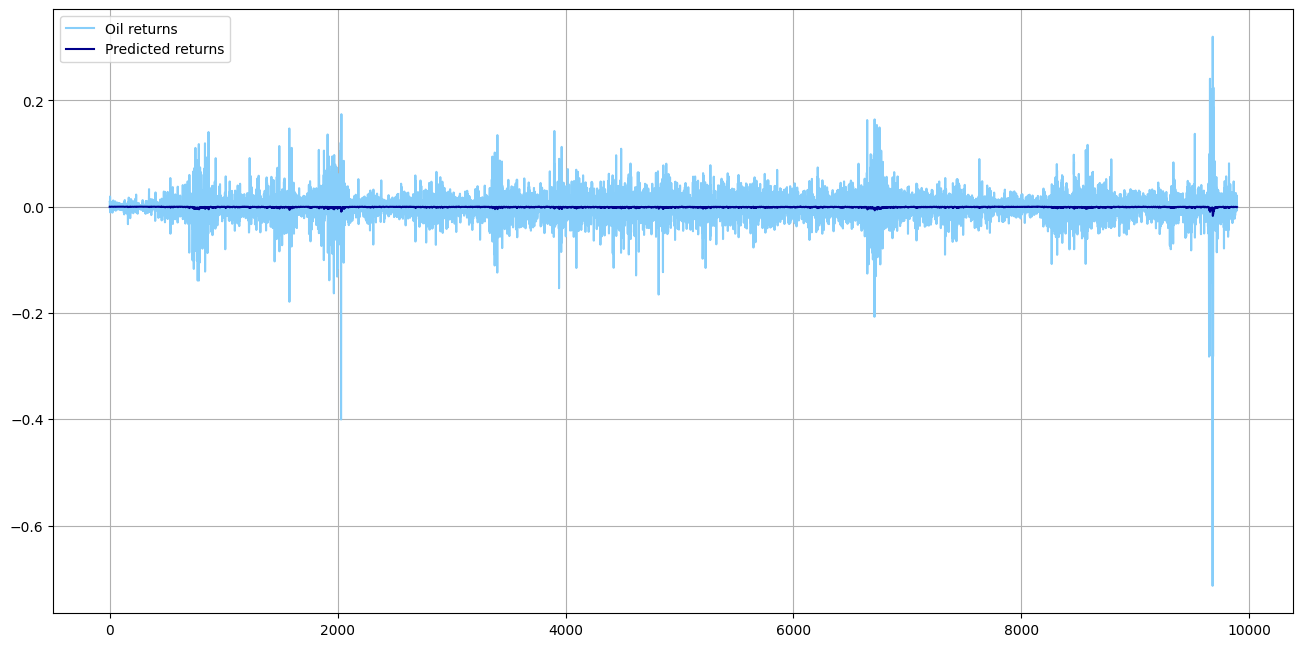

In [707]:
# train data
train_df_lstm_univariate = pd.DataFrame()
y_pred_train = lstm_univariate.predict(X_train_univariate)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train_univariate, (1, y_train_univariate.shape[0]))
train_df_lstm_univariate['Prediction'] = y_pred_train[0].tolist()
train_df_lstm_univariate['Real'] = y_train_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(train_df_lstm_univariate.Real, color='lightskyblue', label='Oil returns')
plt.plot(train_df_lstm_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 10ms/step


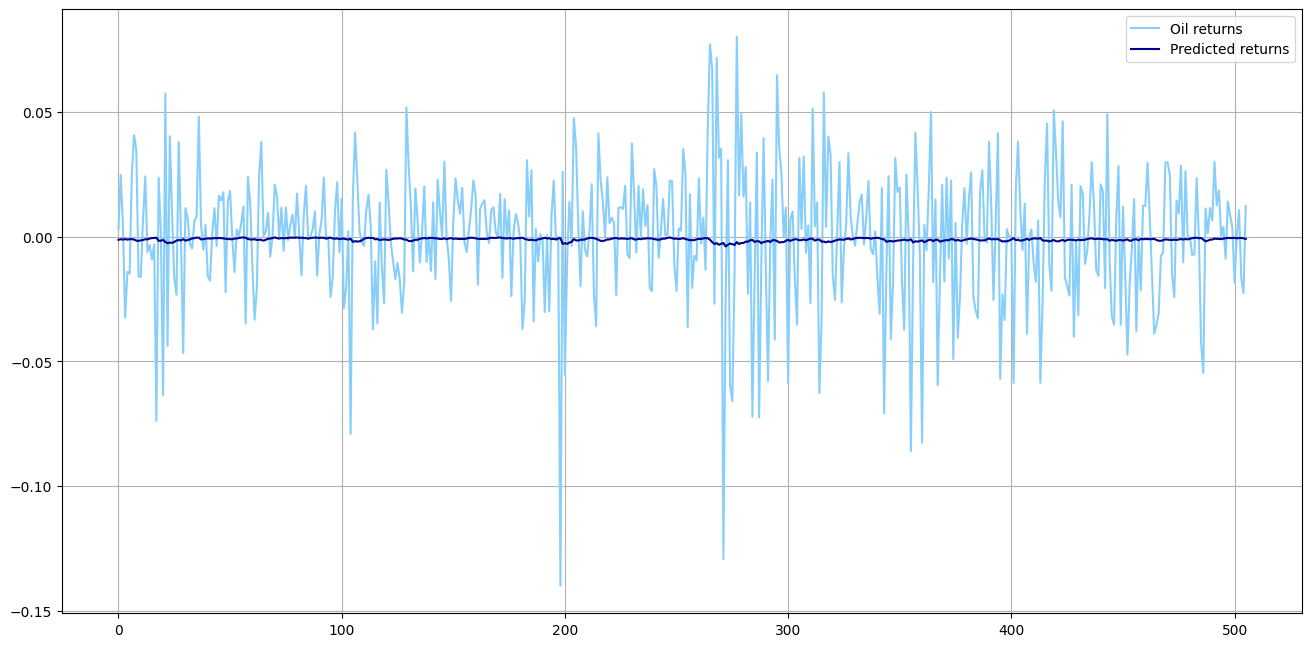

In [708]:
test_df_lstm_univariate = pd.DataFrame()
y_pred_test = lstm_univariate.predict(X_test_univariate)
y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_univariate, (1, y_test_univariate.shape[0]))
test_df_lstm_univariate['Prediction'] = y_pred_test[0].tolist()
test_df_lstm_univariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_univariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

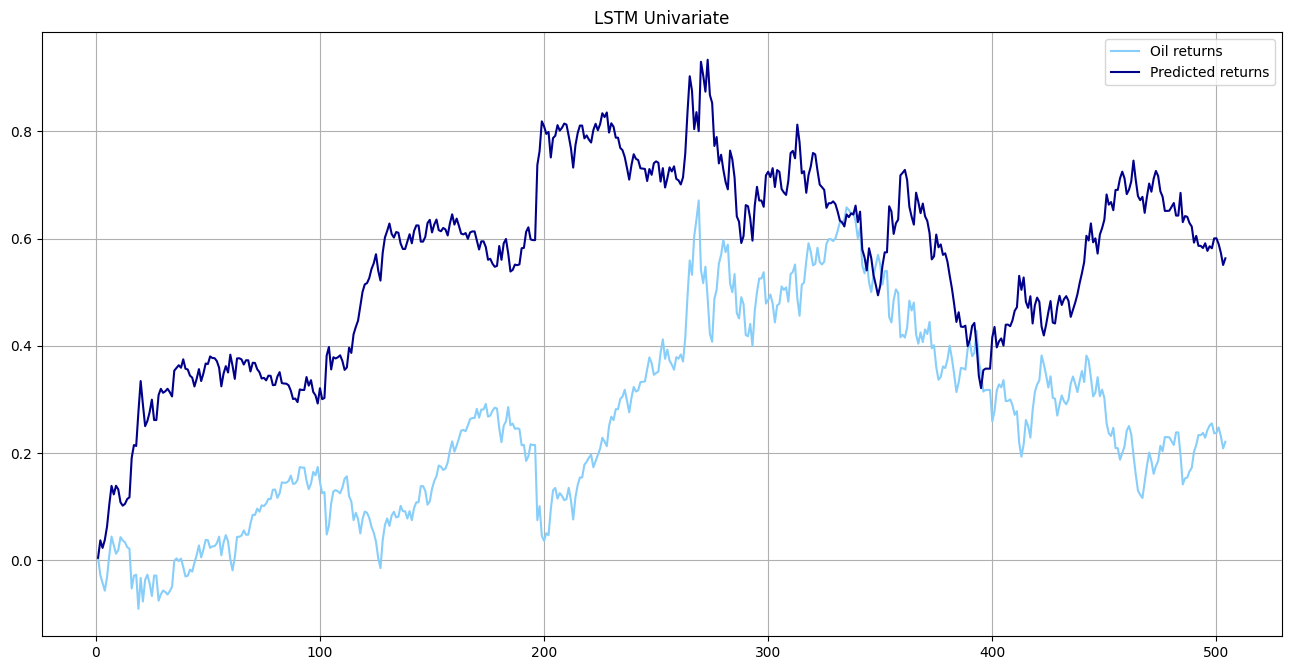

In [709]:
# tor['real'] = np.log(tor['real']).diff()
# tor['pred'] = np.log(tor['pred']).diff()

# tor['real'] = tor.real.pct_change()
# tor['pred'] = tor.pred.pct_change()
# tor['real'] = np.log(tor.real) - np.log(tor.real.shift(1))
# tor['pred'] = np.log(tor.pred) - np.log(tor.pred.shift(1))


test_df_lstm_univariate.dropna(inplace=True)

test_df_lstm_univariate['Oil_returns'] = test_df_lstm_univariate['Reality'].shift(-1)
test_df_lstm_univariate['Predicted_returns'] = test_df_lstm_univariate['Prediction'].shift(-1)

test_df_lstm_univariate['Signal_predicted'] = np.where(test_df_lstm_univariate['Predicted_returns'] > test_df_lstm_univariate['Predicted_returns'].shift(-1), 1, -1)
test_df_lstm_univariate['Signal_real'] = np.where(test_df_lstm_univariate['Oil_returns'] > test_df_lstm_univariate['Oil_returns'].shift(-1),1, -1)


test_df_lstm_univariate['Strategy_returns'] = test_df_lstm_univariate['Signal_predicted'].shift(1) * test_df_lstm_univariate['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
test_df_lstm_univariate.dropna(inplace=True)


test_df_lstm_univariate['Cumulative_real'] = test_df_lstm_univariate['Oil_returns'].cumsum()
test_df_lstm_univariate['Cumulative_strategy'] = test_df_lstm_univariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_univariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_univariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('LSTM Univariate')
plt.legend(loc='best')

In [321]:
test_df_lstm_univariate1 = sharpe_ratio(test_df_lstm_univariate, 'Cumulative_strategy', 504, 0.001)
test_df_lstm_univariate1 = sortino_ratio(test_df_lstm_univariate, 'Cumulative_strategy', 504, 0.001)
test_df_lstm_univariate1 = drawdown_ratio(test_df_lstm_univariate, 'Cumulative_strategy')
test_df_lstm_univariate1['Avg_daily_returns'] = test_df_lstm_univariate1['Strategy_returns'].mean()
test_df_lstm_univariate1['St_dev_of_return'] = test_df_lstm_univariate1['Strategy_returns'].std()

In [310]:
# regression with constant
X_sm = sm.add_constant(test_df_lstm_univariate)
y = X_sm[['Strategy_returns']]
X = X_sm[['const']]
model_const_cnn_uni = sm.OLS(y, X)
test_df_cnn_multivariate_regr_with_only_const = model_const_cnn_uni.fit()
test_df_cnn_multivariate_regr_with_only_const.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 May 2023   Prob (F-statistic):                nan
Time:                        14:04:22   Log-Likelihood:                 1113.8
No. Observations:                 504   AIC:                            -2226.
Df Residuals:                     503   BIC:                            -2221.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.785      0.433      -0.001       0.003
==============================================================================
Omnibus:                       54.283   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.227
Skew:                          -0.439   Prob(JB):                     8.13e-42
Kurtosis:                       5.871   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [311]:
# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')


momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')


ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])


In [312]:
ff_regression_df.columns

Index(['Date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev'], dtype='object')

In [313]:
test = df_multivariate[-test_df_lstm_univariate.shape[0]:]
test.reset_index(inplace=True)
test_df_lstm_univariate['Date'] = test['Date']
test_df_lstm_univariate['Date'] = pd.to_datetime(test_df_lstm_univariate['Date'])
test_df_lstm_univariate = pd.merge(test_df_lstm_univariate, ff_regression_df, on='Date', how='left')
test_df_lstm_univariate.dropna(inplace=True)

In [314]:
# Regression on market factors
y = test_df_lstm_univariate[['Strategy_returns']]
X = test_df_lstm_univariate[['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev', 'Oil_returns']]
X = X.rename(columns={'Oil_returns':'Oil_returns'})

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_lstm_univariate_regr = model.fit() 
test_df_lstm_univariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     7.056
Date:                Mon, 01 May 2023   Prob (F-statistic):           7.96e-09
Time:                        14:04:24   Log-Likelihood:                 1100.9
No. Observations:                 486   AIC:                            -2184.
Df Residuals:                     477   BIC:                            -2146.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.133e-05      0.001     -0.023      0.982      -0.003       0.003
Mkt-RF          0.0006      0.001      0.593      0.554      -0.002       0.003
SMB            -0.0014      0.002     -0.672      0.502      -0.005       0.003
HML             0.0002      0.002      0.064      0.949      -0.005       0.005
RF              0.2945      0.207      1.424      0.155      -0.112       0.701
Mom            -0.0005      0.001     -0.427      0.669      -0.003       0.002
LT_Rev          0.0029      0.003      1.016      0.310      -0.003       0.009
ST_Rev          0.0027      0.001      2.219      0.027       0.000       0.005
Oil_returns     0.2927      0.044      6.711      0.000       0.207       0.378
==============================================================================
Omnibus:                       64.849   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.070
Skew:                           0.223   Prob(JB):                    9.48e-110
Kurtosis:                       7.959   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [315]:
# Momentum
window = 30
momentum_df =  df_multivariate[['c1']]
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Oil_momentum'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test_df_lstm_univariate.shape[0]:]

In [316]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_lstm_univariate.shape[0]:]

In [317]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Oil_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies
test_df_lstm_univariate.reset_index(inplace=True, drop=True)
y = test_df_lstm_univariate[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Oil_carry', 'Oil_momentum']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_lstm_univariate_regr_mom = model.fit() 

test_df_lstm_univariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4029
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.751
Time:                        14:04:26   Log-Likelihood:                 1074.3
No. Observations:                 486   AIC:                            -2141.
Df Residuals:                     482   BIC:                            -2124.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0013      0.001      1.087      0.278      -0.001       0.004
Oil_returns      0.0436      0.045      0.959      0.338      -0.046       0.133
Oil_carry       -0.0207      0.045     -0.456      0.649      -0.110       0.069
Oil_momentum    -0.0131      0.045     -0.287      0.774      -0.102       0.076
==============================================================================
Omnibus:                       55.358   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.915
Skew:                          -0.467   Prob(JB):                     7.80e-43
Kurtosis:                       5.950   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CNN Univariate Time Series Modelling

In [ ]:
tf.random.set_seed(1234)

In [418]:


df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate.set_index('Date', inplace=True)

# Create univariate df
df_univariate = df_multivariate[['c1']]
df_univariate['c1'] = np.log(df_univariate.c1) - np.log(df_univariate.c1.shift(1))
df_univariate.dropna(inplace=True)
df_univariate = np.asarray(df_univariate)

# create univariate windows
train_univariate, test_univariate = df_univariate[:-TEST_SIZE], df_univariate[-TEST_SIZE:]
X_train_univariate, y_train_univariate = create_data_train(train_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)
X_test_univariate, y_test_univariate = create_data_test(test_univariate,  n_future=FUTURE_SIZE, n_past=WINDOW_SIZE)

In [ ]:
def build_model_cnn_univariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=128,
                              step=32), kernel_size = 2, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=2))

 
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


tuner_cnn_univariate = RandomSearch(
        build_model_cnn_univariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
        )

tuner_cnn_univariate.search(
        x=X_train_univariate,
        y=y_train_univariate,
        epochs=100,
        batch_size=128,
        
)

best_model_cnn_univariate = tuner_cnn_univariate.get_best_models(num_models=1)[0]
tuner_cnn_univariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_cnn_univariate.get_best_hyperparameters()[0].values

best_model_cnn_univariate.summary()

In [ ]:
tuner_cnn_univariate.get_best_hyperparameters()[0].values

In [419]:
# Multivariate CNN
cnn_univariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=100,
                                   mode='min')

cnn_univariate.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.009), input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
cnn_univariate.add(MaxPooling1D(pool_size=2))
cnn_univariate.add(Flatten())
cnn_univariate.add(Dropout(0.1))
cnn_univariate.add(Dense(y_train_univariate.shape[1], activation=tf.keras.layers.LeakyReLU(alpha=0.009)))
cnn_univariate.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history_cnn_univariate = cnn_univariate.fit(X_train_univariate, y_train_univariate, validation_split=VALIDATION_SPLIT, epochs=100, batch_size=BATCH_SIZE, callbacks=[early_stopping])

cnn_univariate.evaluate(X_test_univariate, y_test_univariate)
cnn_univariate.evaluate(X_train_univariate, y_train_univariate)


Epoch 1/100


2023-05-01 14:31:49.915427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 12ms/step - loss: 6.0264e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 2/100
 9/70 [==>...........................] - ETA: 0s - loss: 5.7090e-04 - root_mean_squared_error: 0.0239

2023-05-01 14:31:50.971257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 1s 7ms/step - loss: 6.0246e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 6.0233e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 6.0229e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 6.0200e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 6.0176e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 6.0015e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0017 

[0.0007064378587529063, 0.02657889947295189]

In [420]:
cnn_univariate.evaluate(X_test_univariate, y_test_univariate)

16/16 [==============================] - 0s 5ms/step - loss: 7.0786e-04 - root_mean_squared_error: 0.0266


[0.0007078635971993208, 0.02660570666193962]

In [421]:
cnn_univariate.evaluate(X_train_univariate, y_train_univariate)

310/310 [==============================] - 1s 5ms/step - loss: 7.0644e-04 - root_mean_squared_error: 0.0266


[0.0007064378587529063, 0.02657889947295189]

In [414]:
# save model
pickle.dump(cnn_univariate, open('cnn_univariate.pkl', 'wb'))

TypeError: 'DataFrame' object is not callable

In [ ]:
cnn_univariate = pickle.load(open('cnn_univariate.pkl', 'rb'))

310/310 [==============================] - 1s 2ms/step


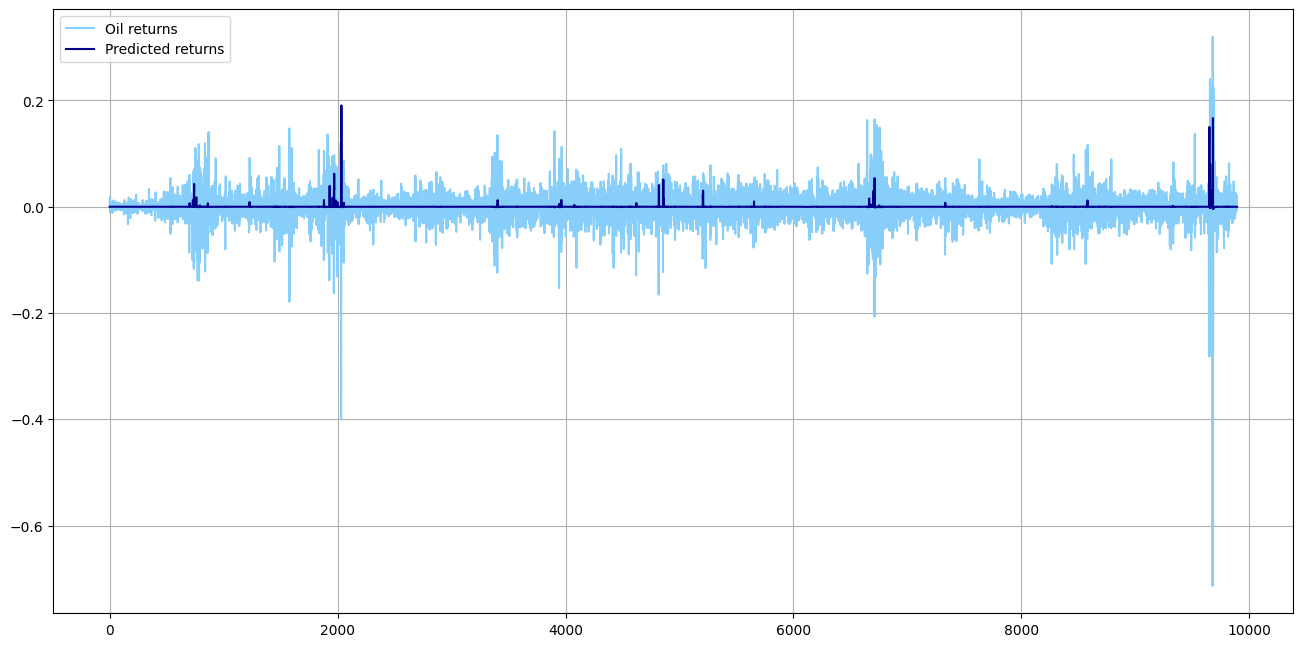

In [710]:
# train data
train_df_cnn_univariate = pd.DataFrame()
y_pred_train = cnn_univariate.predict(X_train_univariate)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train_univariate, (1, y_train_univariate.shape[0]))
train_df_cnn_univariate['Prediction'] = y_pred_train[0].tolist()
train_df_cnn_univariate['Real'] = y_train_real[0].tolist()



plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(train_df_cnn_univariate.Real, color='lightskyblue', label='Oil returns')
plt.plot(train_df_cnn_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 3ms/step


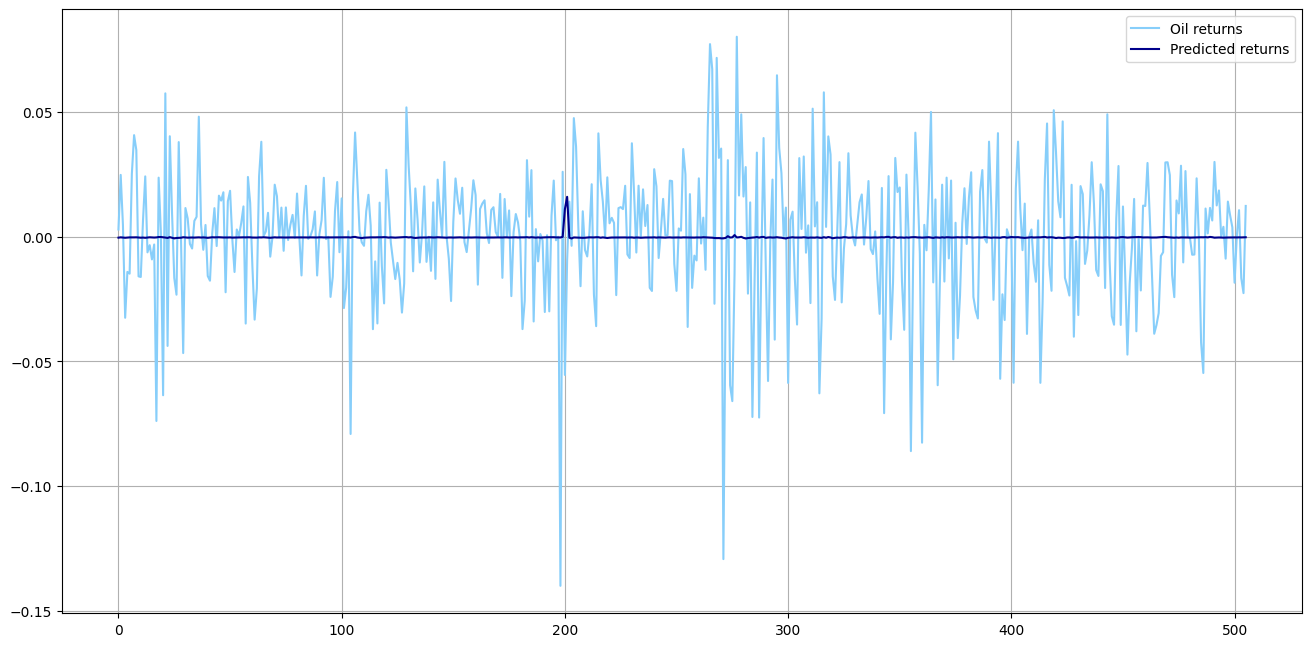

In [711]:
test_df_cnn_univariate = pd.DataFrame()
y_pred_test = cnn_univariate.predict(X_test_univariate)
y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_univariate, (1, y_test_univariate.shape[0]))
test_df_cnn_univariate['Prediction'] = y_pred_test[0].tolist()
test_df_cnn_univariate['Reality'] = y_test_real[0].tolist()





plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_univariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_univariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

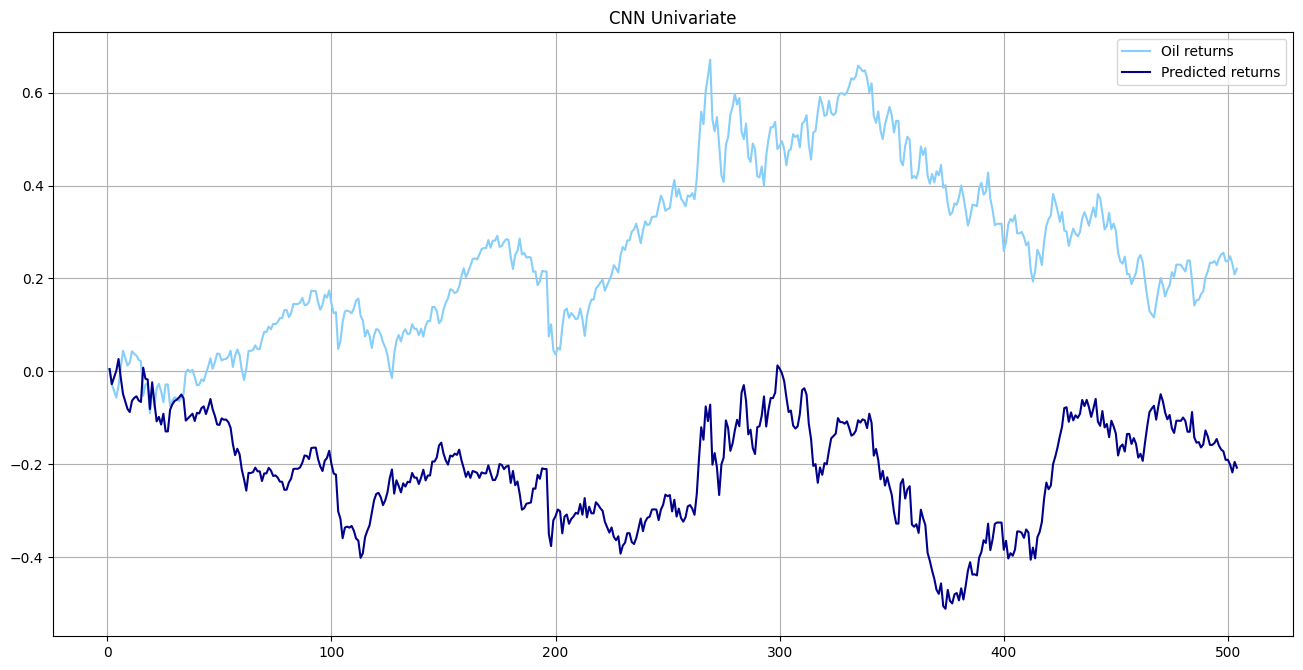

In [712]:
# tor['real'] = np.log(tor['real']).diff()
# tor['pred'] = np.log(tor['pred']).diff()

# tor['real'] = tor.real.pct_change()
# tor['pred'] = tor.pred.pct_change()
# tor['real'] = np.log(tor.real) - np.log(tor.real.shift(1))
# tor['pred'] = np.log(tor.pred) - np.log(tor.pred.shift(1))




test_df_cnn_univariate.dropna(inplace=True)

test_df_cnn_univariate['Oil_returns'] = test_df_cnn_univariate['Reality'].shift(-1)
test_df_cnn_univariate['Predicted_returns'] = test_df_cnn_univariate['Prediction'].shift(-1)

test_df_cnn_univariate['Signal_predicted'] = np.where(test_df_cnn_univariate['Predicted_returns'] > test_df_cnn_univariate['Predicted_returns'].shift(-1), 1, -1)
test_df_cnn_univariate['Signal_real'] = np.where(test_df_cnn_univariate['Oil_returns'] > test_df_cnn_univariate['Oil_returns'].shift(-1),1, -1)


test_df_cnn_univariate['Strategy_returns'] = test_df_cnn_univariate['Signal_predicted'].shift(1) * test_df_cnn_univariate['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
test_df_cnn_univariate.dropna(inplace=True)


test_df_cnn_univariate['Cumulative_real'] = test_df_cnn_univariate['Oil_returns'].cumsum()
test_df_cnn_univariate['Cumulative_strategy'] = test_df_cnn_univariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_univariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_univariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('CNN Univariate')
plt.legend(loc='best')

In [448]:
test_df_cnn_univariate.tail()

,Prediction,Reality,Real_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy
500,-0.000252,-0.018424,0.000250,-0.000268,-1,-1,0.000250,0.237279,-0.190521
501,-0.000268,0.000250,0.010673,-0.000229,1,1,-0.010673,0.247952,-0.201194
502,-0.000229,0.010673,-0.016554,-0.000254,-1,1,-0.016554,0.231398,-0.217748
503,-0.000254,-0.016554,-0.022593,-0.000202,-1,-1,0.022593,0.208805,-0.195155
504,-0.000202,-0.022593,0.012375,-0.000188,-1,-1,-0.012375,0.221180,-0.207530


In [449]:
#OK
test_df_cnn_univariate1 = sharpe_ratio(test_df_cnn_univariate, 'Cumulative_strategy', 504, 0.001)
test_df_cnn_univariate1 = sortino_ratio(test_df_cnn_univariate, 'Cumulative_strategy', 504, 0.001)
test_df_cnn_univariate1 = drawdown_ratio(test_df_cnn_univariate, 'Cumulative_strategy')
test_df_cnn_univariate1['Avg_daily_returns'] = test_df_cnn_univariate1['Strategy_returns'].mean()
test_df_cnn_univariate1['St_dev_of_return'] = test_df_cnn_univariate1['Strategy_returns'].std()


In [ ]:
X_sm = sm.add_constant(test_df_cnn_univariate)
X_sm.head()

In [438]:
# regression with constant
X_sm = sm.add_constant(test_df_cnn_univariate)
y = X_sm[['Strategy_returns']]
X = X_sm[['const']]
model_const_cnn_uni = sm.OLS(y, X)
test_df_cnn_multivariate_regr_with_only_const = model_const_cnn_uni.fit()
test_df_cnn_multivariate_regr_with_only_const.summary()



# y = test_df_cnn_multivariate[['Strategy_returns']]
# X = test_df_cnn_multivariate[['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'Oil_returns']]
# X_sm = sm.add_constant(X)
# model = sm.OLS(y, X_sm)
# test_df_cnn_multivariate_regr = model.fit() 
# test_df_cnn_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 May 2023   Prob (F-statistic):                nan
Time:                        14:34:04   Log-Likelihood:                 1113.5
No. Observations:                 504   AIC:                            -2225.
Df Residuals:                     503   BIC:                            -2221.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.348      0.728      -0.003       0.002
==============================================================================
Omnibus:                       54.881   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.019
Skew:                          -0.467   Prob(JB):                     8.12e-40
Kurtosis:                       5.775   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [439]:

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])


In [440]:
test = df_multivariate[-test_df_cnn_univariate.shape[0]:]
test.reset_index(inplace=True)
test_df_cnn_univariate['Date'] = test['Date']
test_df_cnn_univariate['Date'] = pd.to_datetime(test_df_cnn_univariate['Date'])
test_df_cnn_univariate = pd.merge(test_df_cnn_univariate, ff_regression_df, on='Date', how='left')
test_df_cnn_univariate.dropna(inplace=True)

In [441]:
# Regression on market factors
y = test_df_cnn_univariate[['Strategy_returns']]

X = test_df_cnn_univariate[['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev',	'Oil_returns']]

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_cnn_multivariate_regr = model.fit() 

test_df_cnn_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.298
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0201
Time:                        14:34:06   Log-Likelihood:                 1082.3
No. Observations:                 486   AIC:                            -2147.
Df Residuals:                     477   BIC:                            -2109.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0007      0.001     -0.497      0.619      -0.004       0.002
Mkt-RF          -0.0010      0.001     -0.864      0.388      -0.003       0.001
SMB              0.0031      0.002      1.479      0.140      -0.001       0.007
HML              0.0040      0.003      1.598      0.111      -0.001       0.009
RF               0.1285      0.215      0.598      0.550      -0.294       0.551
Mom              0.0002      0.001      0.163      0.871      -0.002       0.003
LT_Rev          -0.0033      0.003     -1.123      0.262      -0.009       0.003
ST_Rev           0.0014      0.001      1.115      0.265      -0.001       0.004
Real_returns     0.1628      0.045      3.593      0.000       0.074       0.252
==============================================================================
Omnibus:                       22.827   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.667
Skew:                          -0.108   Prob(JB):                     6.70e-14
Kurtosis:                       4.717   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [442]:
# Momentum strategy
window = 30
momentum_df =  df_multivariate[['c1']]
momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['Oil_returns'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["Oil_returns"]
momentum_df = momentum_df[-test_df_cnn_univariate.shape[0]:]


In [443]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_cnn_univariate.shape[0]:]




In [444]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["Oil_returns"] * strategies_df["carry"]
# Regression on both of strategies

test_df_cnn_univariate.reset_index(inplace=True, drop=True)
y = test_df_cnn_univariate[['Strategy_returns']]
X = strategies_df[['Oil_returns', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_cnn_multivariate_regr_mom = model.fit() 

test_df_cnn_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.767
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.153
Time:                        14:34:08   Log-Likelihood:                 1075.8
No. Observations:                 486   AIC:                            -2144.
Df Residuals:                     482   BIC:                            -2127.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002      0.001     -0.152      0.879      -0.003       0.002
Real_returns        -0.0595      0.045     -1.312      0.190      -0.149       0.030
Strat_real_carry    -0.0237      0.045     -0.522      0.602      -0.113       0.065
Strat_real_mom      -0.0820      0.045     -1.807      0.071      -0.171       0.007
==============================================================================
Omnibus:                       55.434   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.684
Skew:                          -0.517   Prob(JB):                     2.35e-37
Kurtosis:                       5.694   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# LSTM Multivariate Time Series Modelling

In [536]:
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate.columns

Index(['Date', 'c1', 'Spread', 'NCL_LTD', 'Shift', 'Year', 'Month', 'Quarter',
       'Day', 'Week', 'DGS1', 'DGS10', 'VIXCLS', 'Inventories', 'Rig_actual',
       'Prod_actual', 'GDP', 'CPIAUCSL', 'Return_sp', 'Return_nasdaq',
       'Fin_Score', 'Sentiment_label', 'Sentiment_present', 'Trend'],
      dtype='object')

In [655]:
# tf.random.set_seed(1234)
df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate['c1'] = np.log(df_multivariate.c1) - np.log(df_multivariate.c1.shift(1))
df_multivariate.dropna(inplace=True)
df_multivariate.set_index('Date', inplace=True)

train = df_multivariate[:-TEST_SIZE]
test = df_multivariate[-TEST_SIZE:]

scaler1 = MinMaxScaler(feature_range=(0,1))
scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# I could do: split train test, 

X_train, y_train = [], []
for i in range(len(train) - WINDOW_SIZE):
    row = [r for r in train[i:i+WINDOW_SIZE]]
    X_train.append(row)
    label = train[i+WINDOW_SIZE][0]
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = [], []
for i in range(len(test) - WINDOW_SIZE):
    row = [r for r in test[i:i+WINDOW_SIZE]]
    X_test.append(row)
    label = test[i+WINDOW_SIZE][0]
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
# Tuning the hyperparameters of the network

def build_model_lstm_multivariate(hp):

  ''''
  Function to optimize the lstm model
  '''
  
  model = Sequential()

  # model.add(LSTM(hp.Int('input_unit' ,min_value=16, max_value=128, step=32), return_sequences=True, input_shape=(X_train_univariate.shape[1], X_train_univariate.shape[2])))
  
  for i in range(hp.Int('n_layers', 1, 2)):

    model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=16, max_value=256, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))
  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])

  return model


tuner_lstm_multivariate = RandomSearch(
        build_model_lstm_multivariate,
        objective='mse',
        max_trials=5,
        executions_per_trial=5
)

tuner_lstm_multivariate.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=128,
)

best_model_lstm_multivariate = tuner_lstm_multivariate.get_best_models(num_models=1)[0]
tuner_lstm_multivariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)

tuner_lstm_multivariate.get_best_hyperparameters()[0].values

best_model_lstm_multivariate.summary()


In [ ]:
tuner_lstm_multivariate.get_best_hyperparameters()[0].values

In [656]:
lstm_multivariate = Sequential()

early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   mode='min')
lstm_multivariate.add(LSTM(208, activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
lstm_multivariate.add(LSTM(16, activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=False))

lstm_multivariate.add(Dropout(0.21)) 
lstm_multivariate.add(Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
lstm_multivariate.compile(optimizer='adam' ,loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
lstm_multivariate.summary()
# fit model
history_lstm_multivariate = lstm_multivariate.fit(X_train, y_train, validation_split = VALIDATION_SPLIT,
                              epochs=100, batch_size=BATCH_SIZE, callbacks=early_stopping)
lstm_multivariate.evaluate(X_test, y_test)
lstm_multivariate.evaluate(X_train, y_train)

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 208)            193024    
                                                                 
 lstm_31 (LSTM)              (None, 16)                14400     
                                                                 
 dropout_53 (Dropout)        (None, 16)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 207,441
Trainable params: 207,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-05-01 17:26:35.153515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 0.0535 - root_mean_squared_error: 0.2313

2023-05-01 17:26:42.368250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 10s 98ms/step - loss: 0.0535 - root_mean_squared_error: 0.2313 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 2/100
70/70 [==============================] - 6s 83ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 3/100
70/70 [==============================] - 6s 84ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 4/100
70/70 [==============================] - 6s 83ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 5/100
70/70 [==============================] - 6s 86ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 6/100
70/70 [==============================] - 6s 88ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0016 - val_root_mean_s

[0.0006630724528804421, 0.025750193744897842]

In [657]:
lstm_multivariate.evaluate(X_test, y_test)

16/16 [==============================] - 0s 16ms/step - loss: 6.7270e-04 - root_mean_squared_error: 0.0259


[0.0006726993597112596, 0.02593645080924034]

In [658]:
lstm_multivariate.evaluate(X_train, y_train)

310/310 [==============================] - 5s 16ms/step - loss: 6.6307e-04 - root_mean_squared_error: 0.0258


[0.0006630724528804421, 0.025750193744897842]

In [ ]:
# save model
pickle.dump(lstm_multivariate, open('lstm_multivariate.pkl', 'wb'))

In [ ]:
lstm_multivariate = pickle.load(open('lstm_multivariate.pkl', 'rb'))

310/310 [==============================] - 4s 14ms/step


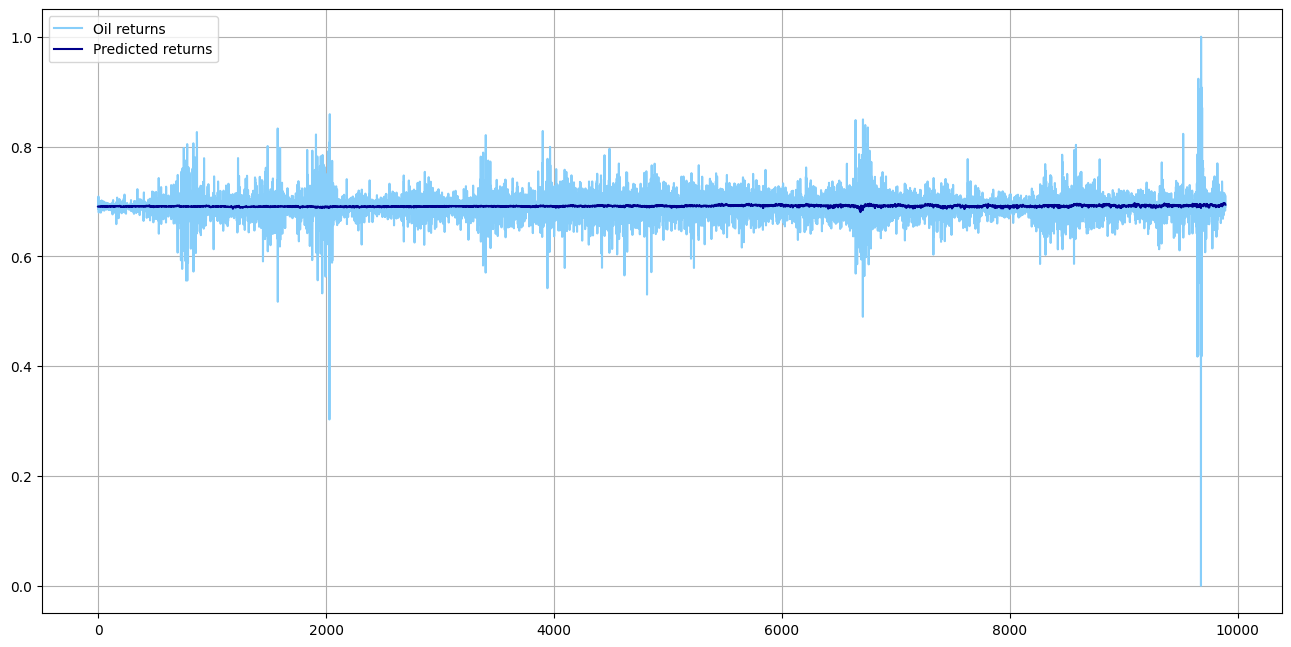

In [713]:
test_df_lstm_multivariate = pd.DataFrame()
y_pred_train = lstm_multivariate.predict(X_train)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train, (1, y_train.shape[0]))
test_df_lstm_multivariate['Prediction'] = y_pred_train[0].tolist()
test_df_lstm_multivariate['Reality'] = y_train_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')


16/16 [==============================] - 0s 19ms/step


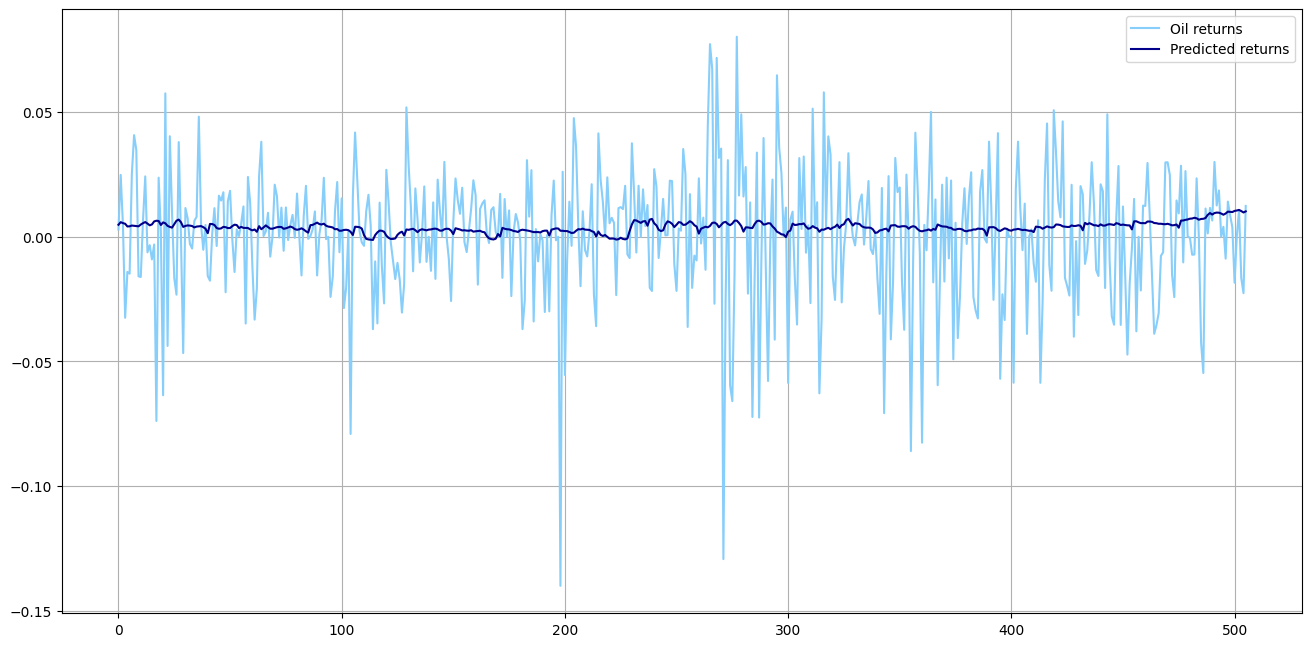

In [714]:
test_df_lstm_multivariate = pd.DataFrame()
y_pred_test = lstm_multivariate.predict(X_test)
y_pred_test = np.repeat(y_pred_test, train.shape[1], axis=-1)
y_pred_test = scaler.inverse_transform(y_pred_test)[:,0]

y_test_real = y_test.reshape((y_test.shape[0], 1))
y_test_real = np.repeat(y_test_real, train.shape[1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_real)[:,0]

y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_real, (1, y_test_real.shape[0]))
test_df_lstm_multivariate['Prediction'] = y_pred_test[0].tolist()
test_df_lstm_multivariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

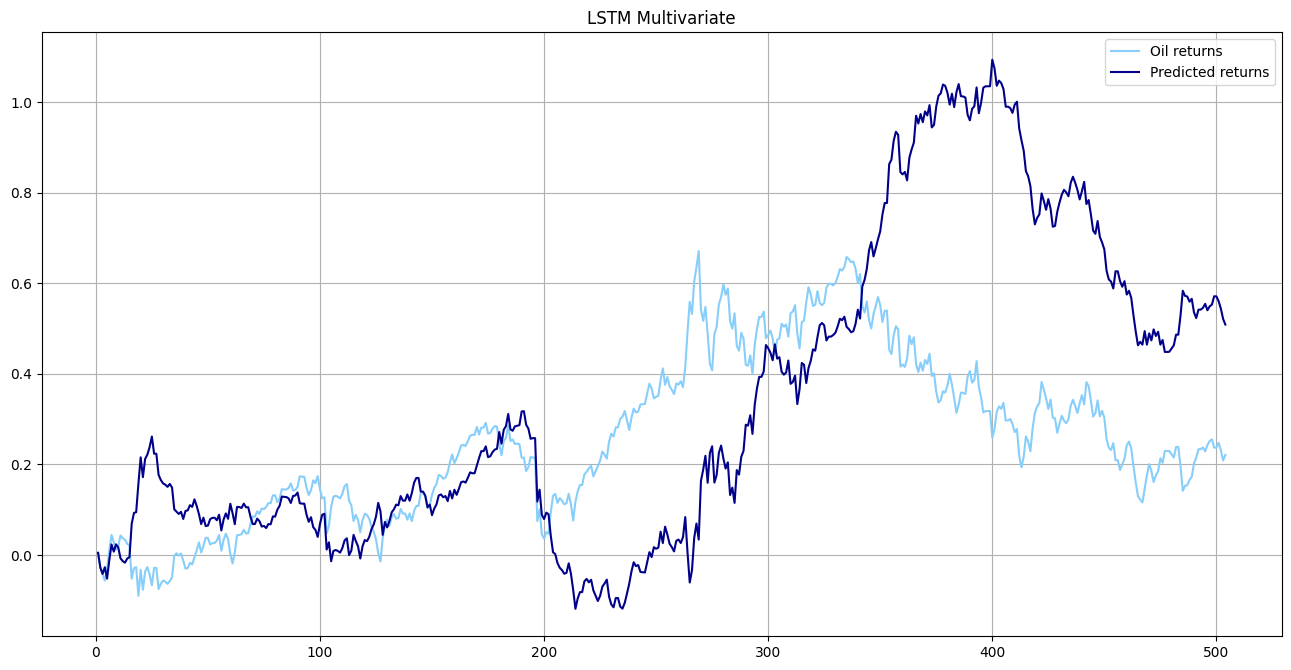

In [715]:
# tor['real'] = np.log(tor['real']).diff()
# tor['pred'] = np.log(tor['pred']).diff()

# tor['real'] = tor.real.pct_change()
# tor['pred'] = tor.pred.pct_change()
# tor['real'] = np.log(tor.real) - np.log(tor.real.shift(1))
# tor['pred'] = np.log(tor.pred) - np.log(tor.pred.shift(1))


test_df_lstm_multivariate.dropna(inplace=True)

test_df_lstm_multivariate['Oil_returns'] = test_df_lstm_multivariate['Reality'].shift(-1)
test_df_lstm_multivariate['Predicted_returns'] = test_df_lstm_multivariate['Prediction'].shift(-1)


test_df_lstm_multivariate['Signal_predicted'] = np.where(test_df_lstm_multivariate['Predicted_returns'] > test_df_lstm_multivariate['Predicted_returns'].shift(-1), 1, -1)
test_df_lstm_multivariate['Signal_real'] = np.where(test_df_lstm_multivariate['Oil_returns'] > test_df_lstm_multivariate['Oil_returns'].shift(-1),1, -1)


test_df_lstm_multivariate['Strategy_returns'] = test_df_lstm_multivariate['Signal_predicted'].shift(1) * test_df_lstm_multivariate['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
test_df_lstm_multivariate.dropna(inplace=True)





test_df_lstm_multivariate['Cumulative_real'] = test_df_lstm_multivariate['Oil_returns'].cumsum()
test_df_lstm_multivariate['Cumulative_strategy'] = test_df_lstm_multivariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_lstm_multivariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_lstm_multivariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('LSTM Multivariate')
plt.legend(loc='best')

In [664]:
#OK
test_df_lstm_multivariate1 = sharpe_ratio(test_df_lstm_multivariate, 'Cumulative_strategy', 504, 0.001)
test_df_lstm_multivariate1 = sortino_ratio(test_df_lstm_multivariate, 'Cumulative_strategy', 504, 0.01)
test_df_lstm_multivariate1 = drawdown_ratio(test_df_lstm_multivariate, 'Cumulative_strategy')
test_df_lstm_multivariate1['Avg_daily_returns'] = test_df_lstm_multivariate1['Strategy_returns'].mean()
test_df_lstm_multivariate1['St_dev_of_return'] = test_df_lstm_multivariate1['Strategy_returns'].std()

In [680]:
test_df_lstm_multivariate1

,Prediction,Reality,Real_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy,sharpe,sharpe_annualized,sortino,sortino_annualized,drawdown,Avg_daily_returns,St_dev_of_return
1,0.005867,0.024823,0.004892,0.005492,1,1,0.004892,0.004892,0.004892,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
2,0.005492,0.004892,-0.032475,0.005227,1,-1,-0.032475,-0.027584,-0.027584,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
3,0.005227,-0.032475,-0.014082,0.004149,-1,1,-0.014082,-0.041666,-0.041666,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
4,0.004149,-0.014082,-0.014786,0.004205,-1,-1,0.014786,-0.056452,-0.026880,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
5,0.004205,-0.014786,0.025284,0.004510,1,-1,-0.025284,-0.031167,-0.052165,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
6,0.004510,0.025284,0.040770,0.004403,1,1,0.040770,0.009603,-0.011395,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
7,0.004403,0.040770,0.034794,0.004277,1,1,0.034794,0.044397,0.023399,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
8,0.004277,0.034794,-0.015861,0.004197,-1,1,-0.015861,0.028535,0.007538,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
9,0.004197,-0.015861,-0.016117,0.004919,-1,-1,0.016117,0.012419,0.023655,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571
10,0.004919,-0.016117,0.006695,0.005467,-1,-1,-0.006695,0.019114,0.016960,1.009664,0.508871,9.678478,4.877953,-0.938155,0.00101,0.026571


In [668]:
# regression with constant
X_sm = sm.add_constant(test_df_lstm_multivariate)
y = X_sm[['Cumulative_strategy']]
X = X_sm[['const']]
model_const_lstm_multi = sm.OLS(y, X)
test_df_lstm_multivariate_regr_with_only_const = model_const_lstm_multi.fit()
test_df_lstm_multivariate_regr_with_only_const.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Cumulative_strategy   R-squared:                      -0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                       nan
Date:                 Mon, 01 May 2023   Prob (F-statistic):                nan
Time:                         17:55:33   Log-Likelihood:                -167.89
No. Observations:                  504   AIC:                             337.8
Df Residuals:                      503   BIC:                             342.0
Df Model:                            0                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3412      0.015     22.667      0.000       0.312       0.371
==============================================================================
Omnibus:                       72.266   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.327
Skew:                           0.681   Prob(JB):                     4.34e-12
Kurtosis:                       2.202   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [669]:

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])

In [670]:
test = df_multivariate[-test_df_lstm_multivariate.shape[0]:]
test.reset_index(inplace=True)
test_df_lstm_multivariate['Date'] = test['Date']

test_df_lstm_multivariate['Date'] = pd.to_datetime(test_df_lstm_multivariate['Date'])
test_df_lstm_multivariate = pd.merge(test_df_lstm_multivariate, ff_regression_df, on='Date', how='left')
test_df_lstm_multivariate.dropna(inplace=True)

In [671]:
# Regression on market factors
y = test_df_lstm_multivariate[['Strategy_returns']]
X = test_df_lstm_multivariate[['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev',	'Oil_returns']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)
test_df_lstm_multivariate_regr = model.fit() 
test_df_lstm_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.481
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.161
Time:                        17:55:35   Log-Likelihood:                 1079.2
No. Observations:                 486   AIC:                            -2140.
Df Residuals:                     477   BIC:                            -2103.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0023      0.001      1.596      0.111      -0.001       0.005
Mkt-RF          -0.0016      0.001     -1.441      0.150      -0.004       0.001
SMB              0.0002      0.002      0.092      0.926      -0.004       0.004
HML             -0.0008      0.003     -0.321      0.748      -0.006       0.004
RF              -0.4259      0.216     -1.969      0.050      -0.851      -0.001
Mom             -0.0014      0.001     -1.213      0.226      -0.004       0.001
LT_Rev           0.0017      0.003      0.568      0.570      -0.004       0.008
ST_Rev          -0.0015      0.001     -1.194      0.233      -0.004       0.001
Real_returns    -0.0193      0.046     -0.424      0.672      -0.109       0.070
==============================================================================
Omnibus:                       42.057   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.615
Skew:                          -0.228   Prob(JB):                     5.42e-38
Kurtosis:                       5.875   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [672]:
strategies_df.isna().sum()

Date                 0
c1                   0
Prior_n_real         0
Position_real_mom    0
Strat_real_mom       0
carry                0
Strat_real_carry     0
dtype: int64

In [673]:
# Regression on oil factors

# Momentum strategy

window = 30
momentum_df =  df_multivariate[['c1']]

#momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))

momentum_df['Prior_n_real'] = momentum_df['c1'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["c1"]

momentum_df = momentum_df[-test_df_lstm_multivariate.shape[0]:]
momentum_df = momentum_df.reset_index()
momentum_df['Date'] = pd.to_datetime(momentum_df['Date'])


In [674]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)


carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_lstm_multivariate.shape[0]:]
carry_df['Date'] = pd.to_datetime(carry_df['Date'])

In [675]:
test_df_lstm_multivariate.shape

(486, 17)

In [676]:
carry_df.shape

(486, 4)

In [677]:
strategies_df.head()

,Date,c1,Prior_n_real,Position_real_mom,Strat_real_mom,carry,Strat_real_carry
0,2021-02-25,0.004892,0.170523,1,0.004892,1.0,0.004892
1,2021-02-26,-0.032475,0.160894,1,-0.032475,-1.0,0.032475
2,2021-03-01,-0.014082,0.146812,1,-0.014082,1.0,-0.014082
3,2021-03-02,-0.014786,0.120255,1,-0.014786,1.0,-0.014786
4,2021-03-03,0.025284,0.140644,1,0.025284,1.0,0.025284


In [679]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["c1"] * strategies_df["carry"]
# Regression on both of strategies
test_df_lstm_multivariate.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = test_df_lstm_multivariate[['Strategy_returns']]
X = strategies_df[['c1',  'Strat_real_mom', 'Strat_real_carry']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_lstm_multivariate_regr_mom = model.fit() 

test_df_lstm_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.452
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0627
Time:                        17:58:59   Log-Likelihood:                 1077.0
No. Observations:                 486   AIC:                            -2146.
Df Residuals:                     482   BIC:                            -2129.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0007      0.001      0.577      0.564      -0.002       0.003
c1                   0.1139      0.045      2.518      0.012       0.025       0.203
Strat_real_mom       0.0110      0.045      0.243      0.808      -0.078       0.100
Strat_real_carry     0.0423      0.045      0.935      0.350      -0.047       0.131
==============================================================================
Omnibus:                       38.165   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.389
Skew:                          -0.172   Prob(JB):                     1.34e-33
Kurtosis:                       5.712   Cond. No.                         38.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# CNN Multivariate Time Series Modelling

In [ ]:
TEST_SIZE

In [579]:
# tf.random.set_seed(1234)



df_multivariate = pd.read_parquet('oil_best_feats_v3.parquet')
df_multivariate['c1'] = np.log(df_multivariate.c1) - np.log(df_multivariate.c1.shift(1))
df_multivariate.dropna(inplace=True)
df_multivariate.set_index('Date', inplace=True)




# df_multivariate = np.asarray(df_multivariate)
train = df_multivariate[:-TEST_SIZE]
test = df_multivariate[-TEST_SIZE:]

scaler1 = MinMaxScaler()
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

X_train, y_train = [], []
for i in range(len(train) - WINDOW_SIZE):
    row = [r for r in train[i:i+WINDOW_SIZE]]
    X_train.append(row)
    label = train[i+WINDOW_SIZE][0]
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)


X_test, y_test = [], []
for i in range(len(test) - WINDOW_SIZE):
    row = [r for r in test[i:i+WINDOW_SIZE]]
    X_test.append(row)
    label = test[i+WINDOW_SIZE][0]
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)



In [ ]:
def build_model_cnn_multivariate(hp):

  '''
  Function to optimize cnn model
  '''
   
  model = keras.models.Sequential()
  
  model.add(Conv1D(hp.Int('input_units',
                              min_value=32,
                              max_value=256,
                              step=32), kernel_size = 2))
  
  model.add(Activation('relu'))
  model.add(MaxPooling1D(pool_size=2))

 
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0.01, max_value=0.51, step=0.1)))

  model.add(Dense(1, activation=hp.Choice('dense_activation', values=['relu', 'linear', 'tanh', 'elu'], default='relu')))
  
  optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001]))

  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = ['mse'])
  
  return model


tuner_cnn_multivariate = RandomSearch(
        build_model_cnn_multivariate,
        objective='mse',
        max_trials=3,
        executions_per_trial=3
        )

tuner_cnn_multivariate.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=128,
        
)

best_model_cnn_multivariate = tuner_cnn_multivariate.get_best_models(num_models=1)[0]
tuner_cnn_multivariate.results_summary()

# with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
#     pickle.dump(tuner, f)


tuner_cnn_multivariate.get_best_hyperparameters()[0].values

best_model_cnn_multivariate.summary()

In [ ]:
tuner_cnn_multivariate.get_best_hyperparameters()[0].values

In [580]:
# assumption, need to fix
# tf.random.set_seed(42)

cnn_multivariate = Sequential()
early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   mode='min')
cnn_multivariate.add(Conv1D(filters=128, kernel_size=4, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_multivariate.add(MaxPooling1D(pool_size=2))
cnn_multivariate.add(Flatten())
cnn_multivariate.add(Dropout(0.00001))
cnn_multivariate.add(Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.2))) #'relu'

cnn_multivariate.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

cnn_multivariate.summary()

history_cnn_multivariate = cnn_multivariate.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=80, batch_size=64, callbacks=early_stopping)

cnn_multivariate.evaluate(X_test, y_test)
cnn_multivariate.evaluate(X_train, y_train)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 2, 128)            11904     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 1, 128)           0         
 g1D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 128)               0         
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 1)                 129       
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________

2023-05-01 17:01:34.864247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 2s 11ms/step - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 2/80
  1/140 [..............................] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0356

2023-05-01 17:01:36.375382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 1s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 3/80
140/140 [==============================] - 1s 8ms/step - loss: 9.7420e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 4/80
140/140 [==============================] - 1s 8ms/step - loss: 8.6205e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483
Epoch 5/80
140/140 [==============================] - 1s 7ms/step - loss: 8.6263e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
Epoch 6/80
140/140 [==============================] - 1s 7ms/step - loss: 8.2938e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 7/80
140/140 [==============================] - 1s 7ms/step - loss: 8.4885e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.00

[0.0006370754563249648, 0.025240356102585793]

In [621]:
cnn_multivariate.evaluate(X_test, y_test)

16/16 [==============================] - 0s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368


[0.001354146865196526, 0.036798734217882156]

In [622]:
cnn_multivariate.evaluate(X_train, y_train)

310/310 [==============================] - 2s 5ms/step - loss: 6.3708e-04 - root_mean_squared_error: 0.0252


[0.0006370754563249648, 0.025240356102585793]

310/310 [==============================] - 1s 2ms/step


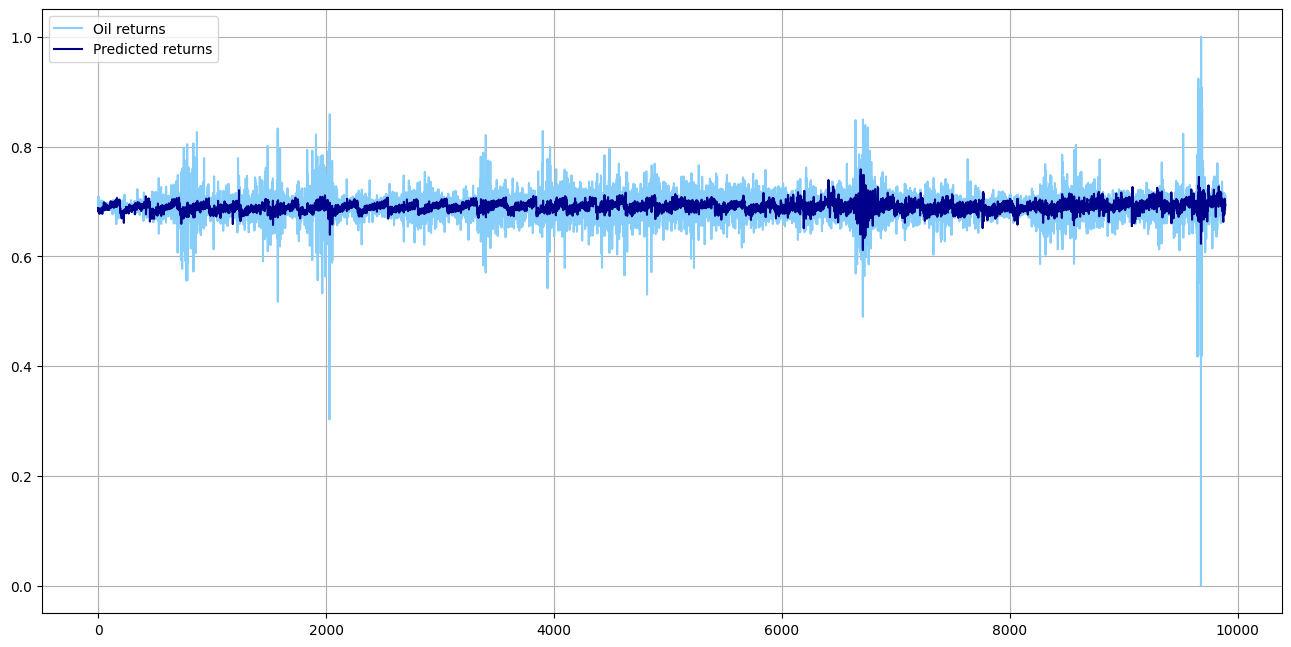

In [716]:
test_df_cnn_multivariate = pd.DataFrame()
y_pred_train = cnn_multivariate.predict(X_train)
y_pred_train = np.reshape(y_pred_train, (1, y_pred_train.shape[0]))
y_train_real = np.reshape(y_train, (1, y_train.shape[0]))
test_df_cnn_multivariate['Prediction'] = y_pred_train[0].tolist()
test_df_cnn_multivariate['Reality'] = y_train_real[0].tolist()


plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

16/16 [==============================] - 0s 3ms/step


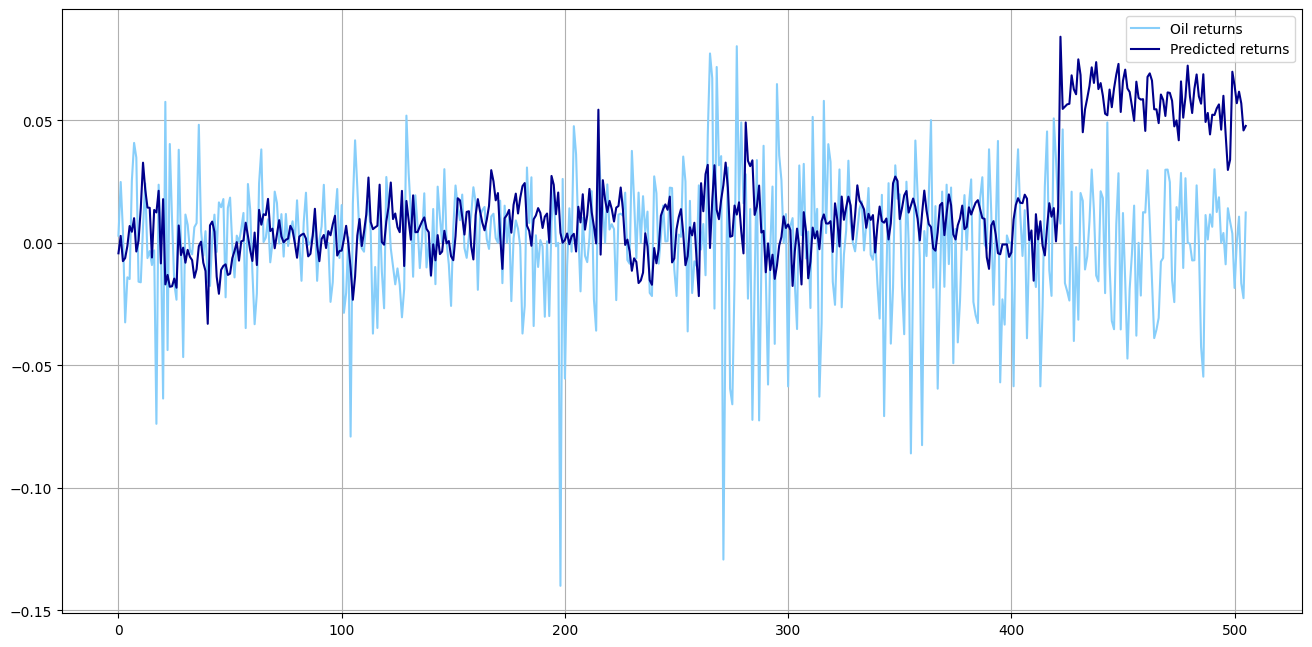

In [717]:
# Pfrediction for out of sample period
test_df_cnn_multivariate = pd.DataFrame()
y_pred_test = cnn_multivariate.predict(X_test)
y_pred_test = np.repeat(y_pred_test, train.shape[1], axis=-1)
y_pred_test = scaler.inverse_transform(y_pred_test)[:,0]

y_test_real = y_test.reshape((y_test.shape[0], 1))
y_test_real = np.repeat(y_test_real, train.shape[1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_real)[:,0]

y_pred_test = np.reshape(y_pred_test, (1, y_pred_test.shape[0]))
y_test_real = np.reshape(y_test_real, (1, y_test_real.shape[0]))
test_df_cnn_multivariate['Prediction'] = y_pred_test[0].tolist()
test_df_cnn_multivariate['Reality'] = y_test_real[0].tolist()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate.Reality, color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate.Prediction, color='darkblue', label='Predicted returns')
plt.legend(loc='best')

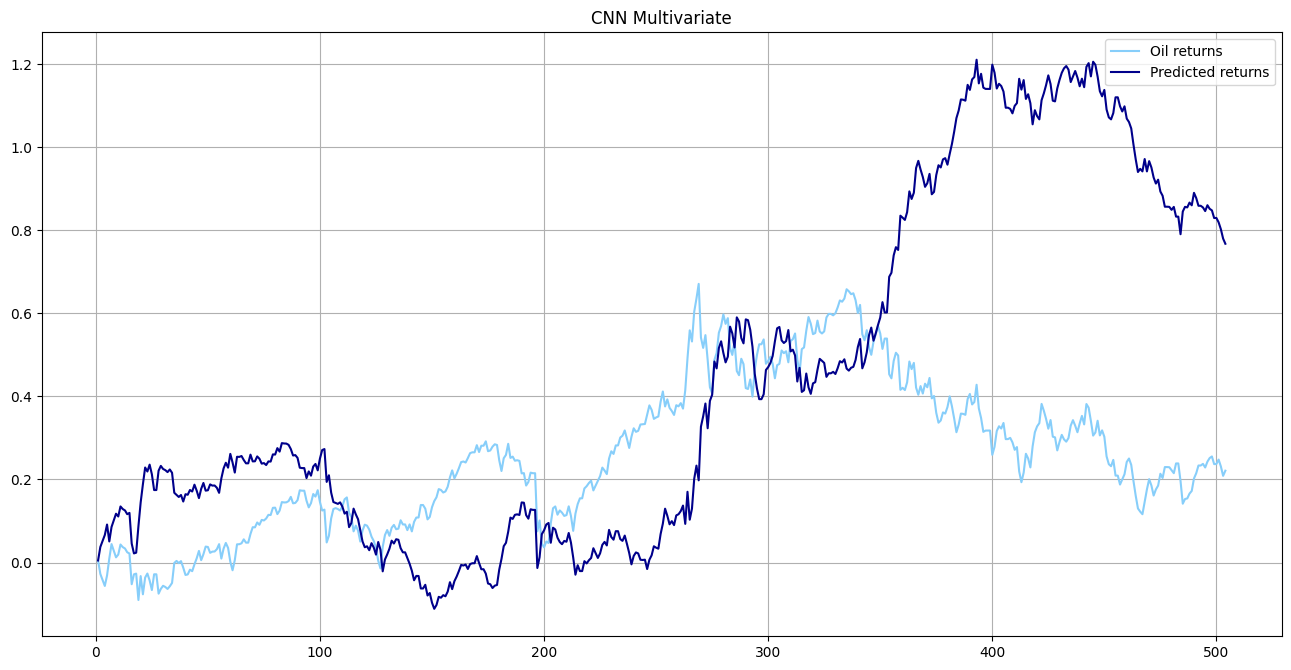

In [718]:
# tor['real'] = np.log(tor['real']).diff()
# tor['pred'] = np.log(tor['pred']).diff()

# tor['real'] = tor.real.pct_change()
# tor['pred'] = tor.pred.pct_change()
# tor['real'] = np.log(tor.real) - np.log(tor.real.shift(1))
# tor['pred'] = np.log(tor.pred) - np.log(tor.pred.shift(1))




test_df_cnn_multivariate.dropna(inplace=True)

test_df_cnn_multivariate['Oil_returns'] = test_df_cnn_multivariate['Reality'].shift(-1)
test_df_cnn_multivariate['Predicted_returns'] = test_df_cnn_multivariate['Prediction'].shift(-1)

test_df_cnn_multivariate['Signal_predicted'] = np.where(test_df_cnn_multivariate['Predicted_returns'] > test_df_cnn_multivariate['Predicted_returns'].shift(-1), 1, -1)
test_df_cnn_multivariate['Signal_real'] = np.where(test_df_cnn_multivariate['Oil_returns'] > test_df_cnn_multivariate['Oil_returns'].shift(-1),1, -1)


test_df_cnn_multivariate['Strategy_returns'] = test_df_cnn_multivariate['Signal_predicted'].shift(1) * test_df_cnn_multivariate['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
test_df_cnn_multivariate.dropna(inplace=True)


test_df_cnn_multivariate['Cumulative_real'] = test_df_cnn_multivariate['Oil_returns'].cumsum()
test_df_cnn_multivariate['Cumulative_strategy'] = test_df_cnn_multivariate['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(test_df_cnn_multivariate['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(test_df_cnn_multivariate['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('CNN Multivariate')
plt.legend(loc='best')

In [632]:
#OK
test_df_cnn_multivariate1 = sharpe_ratio(test_df_cnn_multivariate, 'Cumulative_strategy', 504, 0.001)
test_df_cnn_multivariate1 = sortino_ratio(test_df_cnn_multivariate, 'Cumulative_strategy', 504, 0.0001)
test_df_cnn_multivariate1 = drawdown_ratio(test_df_cnn_multivariate, 'Cumulative_strategy')
test_df_cnn_multivariate1['Avg_daily_returns'] = test_df_cnn_multivariate1['Strategy_returns'].mean()
test_df_cnn_multivariate1['St_dev_of_return'] = test_df_cnn_multivariate1['Strategy_returns'].std()

In [614]:
# Regression on constant
# regression with constant
X_sm = sm.add_constant(test_df_cnn_multivariate)
y = X_sm[['Strategy_returns']]
X = X_sm[['const']]
model_const_cnn_uni = sm.OLS(y, X)
test_df_cnn_multivariate_regr_with_only_const = model_const_cnn_uni.fit()
test_df_cnn_multivariate_regr_with_only_const.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 May 2023   Prob (F-statistic):                nan
Time:                        17:06:29   Log-Likelihood:                 1114.3
No. Observations:                 504   AIC:                            -2227.
Df Residuals:                     503   BIC:                            -2222.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.289      0.198      -0.001       0.004
==============================================================================
Omnibus:                       38.389   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.957
Skew:                           0.050   Prob(JB):                     9.18e-37
Kurtosis:                       5.809   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [615]:
# Regression

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])
# test = data[-246:]
# test.reset_index(inplace=True)





In [616]:
test = df_multivariate[-test_df_cnn_multivariate.shape[0]:]
test.reset_index(inplace=True)
test_df_cnn_multivariate['Date'] = test['Date']
test_df_cnn_multivariate['Date'] = pd.to_datetime(test_df_cnn_multivariate['Date'])
test_df_cnn_multivariate_regr_df = pd.merge(test_df_cnn_multivariate, ff_regression_df, on='Date', how='left')
test_df_cnn_multivariate_regr_df.fillna(0, inplace=True)

In [605]:
test_df_cnn_multivariate.shape

(504, 10)

In [617]:
# Rgression on market factors
y = test_df_cnn_multivariate_regr_df[['Strategy_returns']]
X = test_df_cnn_multivariate_regr_df[[	'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom   ', 'LT_Rev', 'ST_Rev',	'Oil_returns']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
test_df_cnn_multivariate_regr = model.fit() 
test_df_cnn_multivariate_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.107
Date:                Mon, 01 May 2023   Prob (F-statistic):              0.357
Time:                        17:06:35   Log-Likelihood:                 1118.8
No. Observations:                 504   AIC:                            -2220.
Df Residuals:                     495   BIC:                            -2182.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0027      0.001      1.897      0.058   -9.54e-05       0.005
Mkt-RF       -9.237e-05      0.001     -0.081      0.936      -0.002       0.002
SMB              0.0014      0.002      0.651      0.515      -0.003       0.006
HML              0.0012      0.003      0.454      0.650      -0.004       0.006
RF              -0.3105      0.215     -1.445      0.149      -0.732       0.112
Mom             -0.0013      0.001     -1.079      0.281      -0.004       0.001
LT_Rev          -0.0009      0.003     -0.305      0.760      -0.007       0.005
ST_Rev          -0.0014      0.001     -1.097      0.273      -0.004       0.001
Real_returns    -0.0876      0.045     -1.953      0.051      -0.176       0.001
==============================================================================
Omnibus:                       44.172   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.869
Skew:                          -0.136   Prob(JB):                     2.68e-46
Kurtosis:                       6.149   Cond. No.                         353.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [618]:
# Regression on oil factors

# Momentum strategy

window = 30
momentum_df =  df_multivariate[['c1']]
#momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['c1'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["c1"]
momentum_df = momentum_df[-test_df_cnn_multivariate.shape[0]:]




In [619]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-test_df_cnn_multivariate.shape[0]:]




In [609]:
test_df_cnn_multivariate.head()

,Prediction,Reality,Real_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy,Date
1,0.002826,0.024823,0.004892,-0.007479,-1,1,0.004892,0.004892,0.004892,2021-02-26
2,-0.007479,0.004892,-0.032475,-0.006238,-1,-1,0.032475,-0.027584,0.037367,2021-03-01
3,-0.006238,-0.032475,-0.014082,-0.001264,-1,1,0.014082,-0.041666,0.051449,2021-03-02
4,-0.001264,-0.014082,-0.014786,0.006859,1,-1,0.014786,-0.056452,0.066235,2021-03-03
5,0.006859,-0.014786,0.025284,0.004500,-1,-1,0.025284,-0.031167,0.091519,2021-03-04


In [620]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["c1"] * strategies_df["carry"]
# Regression on both of strategies
test_df_cnn_multivariate.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = test_df_cnn_multivariate[['Strategy_returns']]
X = strategies_df[['c1', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_cnn_multivariate_regr_mom = model.fit() 

test_df_cnn_multivariate_regr_mom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.698
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0453
Time:                        17:06:42   Log-Likelihood:                 1118.3
No. Observations:                 504   AIC:                            -2229.
Df Residuals:                     500   BIC:                            -2212.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0016      0.001      1.356      0.176      -0.001       0.004
c1                  -0.0800      0.044     -1.805      0.072      -0.167       0.007
Strat_real_carry    -0.0950      0.044     -2.145      0.032      -0.182      -0.008
Strat_real_mom       0.0233      0.044      0.525      0.600      -0.064       0.110
==============================================================================
Omnibus:                       44.111   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.807
Skew:                           0.000   Prob(JB):                     1.53e-49
Kurtosis:                       6.272   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_sm.head()

# Temporal Fusion Transformer

In [681]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [682]:
# Functions
def time_idx_func(x: pd.DataFrame, date_column: str) -> pd.DataFrame:

    date_range = pd.date_range(
        start=x[date_column].min(),
        end=x[date_column].max(),
        freq='D'
    )

    date_range_df = pd.DataFrame({
        date_column: date_range
    })

    date_range_df[date_column] = date_range_df[date_column]
    date_range_df['time_idx'] = date_range_df.index

    x = pd.merge(x, date_range_df, on=[date_column], how='left')

    return x


def make_category_type(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = df[column].astype(str).astype('category')

    return df


def make_log_columns(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = np.log(df[column] + 1e-8)

    return df 


def rescale_columms(df: pd.DataFrame, column: str) -> pd.DataFrame:

    df[column] = df[column] / 100

    return df


def radial_basis(df: pd.DataFrame, n_periods: int, time_column: str) -> pd.DataFrame:

    
    date_cols = [ "ds"+str(a) for a in list(range(0, n_periods))] 
        
    rbf = RepeatingBasisFunction(n_periods=n_periods,
                                    remainder='passthrough',
                                    column=time_column,
                                    input_range=None)

    rbf.fit(df[[time_column]])

    dates = pd.DataFrame(index=df.index,
                            df=rbf.transform(df[[time_column]]),
                            columns=date_cols)

    return dates



def split_dataset(df: pd.DataFrame, max_encoder_length: int, max_prediction_length: int, training_cutoff: int, first_new: int ,features: list(), categorical_features: list(), group_id_features: list()):

    '''

    '''
    
    training_dataset = TimeSeriesDataSet(

        df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="y",
            group_ids=group_id_features,
            categorical_encoders={},
            time_varying_known_categoricals=categorical_features, 
            time_varying_unknown_reals=["y"],
            time_varying_known_reals = features,
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length)


    validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, df[lambda x: x.time_idx < first_new], min_prediction_idx=training_cutoff + 1)

    return training_dataset, validation_dataset


def create_dataloaders(training_dataset, validation_dataset, batch_size):

    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    return train_dataloader, val_dataloader


def plot_predictions(model, dates_index, predictions):

    model.plot_prediction(dates_index, predictions, idx=0, add_loss_to_title=True)

    plt.show()



def optimize_hyperparams(train_dataloader, val_dataloader, n_trials, n_epochs, model_epochs):

    study = optimize_hyperparameters(

    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=n_trials,
    max_epochs=n_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
    )

    
    with open("test_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    best_params_model = study.best_trial.params
    trainer_params = {'gradient_clip_val':best_params_model['gradient_clip_val'], 'max_epochs':model_epochs}
    best_params_model.pop('gradient_clip_val')
    model_params = best_params_model

    return model_params, trainer_params


def train_model(training_dataset, model_hyperparams,  trainer_hyperparams, train_dataloader, val_dataloader):

    results = pd.DataFrame()

    checkpoint_callback = ModelCheckpoint(dirpath='chkp/', monitor='val_loss', verbose=True, filename='{epoch}-{val_loss:.2f}', save_last=None, save_top_k=1)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=10, verbose=True, mode="min")

    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs") 
    
    trainer = pl.Trainer(
        **trainer_hyperparams,
        gpus=0,
        enable_model_summary=True,
    
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        **model_hyperparams, # set to <= hidden_size
        
        loss=RMSE(), # replace with quantile lossa
        # reduce learning rate if no improvement in validation loss after x epochs
        reduce_on_plateau_patience=4,
    )

    trainer.fit(
                tft,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

  # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    b = raw_predictions.prediction[:,:,0].cpu().detach().numpy()[0]

    df = pd.DataFrame({'time_idx':x['decoder_time_idx'][0],'prediction':b},columns=['time_idx','prediction'])

    results = pd.concat([results, df], axis=0)

    return results

    
def evaluate_results(results, test_data):

    test_data = test_data[['time_idx', 'y', 'Date']]
    results = results.merge(test_data, on = 'time_idx', how = 'left')

    return results

def evaluate_error(df, predicted, real):

    df['error'] = ((df[real] - df[predicted])/df[real]).abs()

    df['mape'] = np.mean(df['error'])

    return df 


def plot_strategies(preds, real_returns_cum, strategy_returs_cum):

  plt.figure(figsize=(16,8))

  plt.plot(preds[real_returns_cum], color='orange', label='Oil futures returns')

  plt.plot(preds[strategy_returs_cum], color='grey', label='Strategy returns')

  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

In [ ]:
trainer_params_tft

In [ ]:
# No for loop

MAX_ENCODER_LENGTH = 252
MAX_PREDICTION_LENGTH = 252
BATCH_SIZE = 128
FEATURE_LIST = [ 'Volume_c1', 'DGS1', 'DGS10',
       'Rig_actual', 'GDP', 'CPIAUCSL', 'Negative_sent', 'Positive_sent',
       'Neutral_sent', 'Compounded']
CATEGORICAL_FEATURES_LIST = [] 
GROUP_ID_FEATURES = ['Cat']

MODEL_HYPERPARAMS = {
                'learning_rate':0.01,
                'dropout':0.1,       
                # 'log_interval':10,
                # 'log_val_interval':1,
                'hidden_size':64,
                'hidden_continuous_size':32,
                # 'reduce_on_plateau_patience':10,
                'attention_head_size':1

}



TRAINER_HYPERPARAMS = {
    'max_epochs':20, 
    'gradient_clip_val': 1.0
}


# Read data
data = pd.read_csv('oil_best_feats_v2.csv')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data['Cat'] = 'Cat'


data['y'] = np.log(data['y']) - np.log(data['y'].shift(1))
data.dropna(inplace=True)
data['y'][-252:] = 0

data1 = data.copy()

first_new = 10004 #data1[data1['y'] == 0]['time_idx'].min()

training_cutoff = first_new - 1 - MAX_PREDICTION_LENGTH 

training_dataset, validation_dataset = split_dataset(data1, MAX_ENCODER_LENGTH, MAX_PREDICTION_LENGTH, training_cutoff=training_cutoff, first_new=first_new, features=FEATURE_LIST, categorical_features=CATEGORICAL_FEATURES_LIST, group_id_features=GROUP_ID_FEATURES)

training_dataloader, val_dataloader = create_dataloaders(training_dataset=training_dataset, validation_dataset=validation_dataset, batch_size=BATCH_SIZE)

#model_params_tft, trainer_params_tft = optimize_hyperparams(train_dataloader=training_dataloader, val_dataloader=val_dataloader, n_epochs=1, n_trials=1,model_epochs=1)

results_tft = train_model(training_dataset, MODEL_HYPERPARAMS, TRAINER_HYPERPARAMS, train_dataloader=training_dataloader, val_dataloader=val_dataloader)

# results_tft = evaluate_results(results=results, test_data=test)

# results_tft1 = evaluate_error(results_tft, 'prediction', 'y')
 






  


In [ ]:

test = pd.read_csv('oil_best_feats_v2.csv')
test = test.reset_index()
test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))
test.dropna(inplace=True)

results2 = pd.merge(results_tft, test[['time_idx', 'y']], on='time_idx', how='left')


results2.dropna(inplace=True)

results2['Oil_returns'] = results2['y'].shift(-1)
results2['Predicted_returns'] = results2['prediction'].shift(-1)

results2['Signal_predicted'] = np.where(results2['Predicted_returns'] > results2['Predicted_returns'].shift(-1), 1, -1)
results2['Signal_real'] = np.where(results2['Oil_returns'] > results2['Oil_returns'].shift(-1),1, -1)


results2['Strategy_returns'] = results2['Signal_predicted'].shift(1) * results2['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
results2.dropna(inplace=True)


results2['Cumulative_real'] = results2['Oil_returns'].cumsum()
results2['Cumulative_strategy'] = results2['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(results2['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(results2['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.legend(loc='best')

In [ ]:
# For loop
MAX_ENCODER_LENGTH = 7
MAX_PREDICTION_LENGTH = 1
BATCH_SIZE = 64
FEATURE_LIST = [ 'Volume_c1', 'DGS1', 'DGS10',
       'Rig_actual', 'GDP', 'CPIAUCSL', 'Negative_sent', 'Positive_sent',
       'Neutral_sent', 'Compounded']
CATEGORICAL_FEATURES_LIST = [] 
GROUP_ID_FEATURES = ['Cat']

MODEL_HYPERPARAMS = {
                'learning_rate':0.05,
                'dropout':0.05,       
                'log_interval':10,
                'log_val_interval':1,
                'hidden_size':64,
                # 'hidden_continuous_size':32,
                # 'reduce_on_plateau_patience':10,
                # 'attention_head_size':1

}



TRAINER_HYPERPARAMS = {
    'max_epochs':1, 
}


# Read data
data = pd.read_csv('oil_best_feats_v2.csv')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data = data.reset_index(drop=True)
data['Cat'] = 'Cat'
test = data[-20:]
lower_bound = len(data)-len(test)
upper_bound = len(data)


for i in range(lower_bound, upper_bound+1):

  data1 = data[:i]

  data1 = data1.reset_index()

  data1.loc[data1.index[i-1:], 'y'] = 0             #
                                                    #
  first_new = data1[data1['y'] == 0]['time_idx'].min()
  
  training_cutoff = first_new - 1 - MAX_PREDICTION_LENGTH 

  training_dataset, validation_dataset = split_dataset(data1, MAX_ENCODER_LENGTH, MAX_PREDICTION_LENGTH, training_cutoff=training_cutoff, first_new=first_new, features=FEATURE_LIST, categorical_features=CATEGORICAL_FEATURES_LIST, group_id_features=GROUP_ID_FEATURES)

  training_dataloader, val_dataloader = create_dataloaders(training_dataset=training_dataset, validation_dataset=validation_dataset, batch_size=BATCH_SIZE)

  model_params, trainer_params = optimize_hyperparams(train_dataloader=training_dataloader, val_dataloader=val_dataloader, n_epochs=1, n_trials=1,model_epochs=1)

  results = train_model(training_dataset, model_params, trainer_params, train_dataloader=training_dataloader, val_dataloader=val_dataloader)

  results_tft = evaluate_results(results=results, test_data=test)

  results_tft = evaluate_error(results_tft, 'prediction', 'y')
 






  


In [ ]:
results_tft

# NHiTS

In [684]:
# FUNCTIONS

def split_dataset_nhits(df: pd.DataFrame, max_encoder_length: int, max_prediction_length: int, training_cutoff: int, first_new: int ,features: list(), categorical_features: list(), group_id_features: list()):

    '''

    '''
    
    training_dataset = TimeSeriesDataSet(

        df[lambda x: x.time_idx <= training_cutoff],
            time_idx="time_idx",
            target="y",
            group_ids=group_id_features,
            categorical_encoders={},
            time_varying_known_categoricals=categorical_features, 
            time_varying_unknown_reals=["y"],
            time_varying_known_reals = features,
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length,
            allow_missing_timesteps=True,
            add_relative_time_idx=False, )

    validation_dataset = validation = TimeSeriesDataSet.from_dataset(training_dataset, df, min_prediction_idx=training_cutoff + 1)

    return training_dataset, validation_dataset

def optimize_hyperparams_nhits(train_dataloader, val_dataloader, n_trials, n_epochs, model_epochs):

    study = optimize_hyperparameters(

    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=n_trials,
    max_epochs=n_epochs,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  
    
    )

    with open("test_study.pkl", "wb") as fout:
        pickle.dump(study, fout)

    best_params_model = study.best_trial.params
    trainer_params = {'gradient_clip_val':best_params_model['gradient_clip_val'], 'max_epochs':model_epochs}
    best_params_model.pop('gradient_clip_val')
    best_params_model.pop('hidden_continuous_size')
    best_params_model.pop('attention_head_size')
    model_params = best_params_model

    return model_params, trainer_params


def train_model_nhits(training_dataset, model_hyperparams,  trainer_hyperparams, train_dataloader, val_dataloader):
    results = pd.DataFrame()

    checkpoint_callback = ModelCheckpoint(dirpath='chkp/', monitor='val_loss', verbose=True, filename='{epoch}-{val_loss:.2f}', save_last=None, save_top_k=1)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=True, mode="min")
    
    trainer = pl.Trainer(
                **trainer_hyperparams,
                gpus=0,
                enable_model_summary=True,
                
                callbacks=[early_stop_callback, checkpoint_callback], 
                limit_train_batches=128,
                enable_checkpointing=True
            )

    net = NHiTS.from_dataset(
                training_dataset,
                **model_hyperparams,
                loss=RMSE(),
            )

    trainer.fit(
                net,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )

    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = NHiTS.load_from_checkpoint(best_model_path)

  
    raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
    b = raw_predictions.prediction[:,:,0].cpu().detach().numpy()[0]

    df = pd.DataFrame({'time_idx':x['decoder_time_idx'][0],'prediction':b},columns=['time_idx','prediction'])

    results = pd.concat([results, df], axis=0)

    return results

def evaluate_results(results, test_data):

    test_data = test_data[['time_idx', 'y', 'Date']]
    results = results.merge(test_data, on = 'time_idx', how = 'left')

    return results

def evaluate_error(df, predicted, real):

    df['error'] = ((df[real] - df[predicted])/df[real]).abs()

    df['mape'] = np.mean(df['error'])

    return df 

    



In [685]:
from pytorch_lightning.callbacks import EarlyStopping

In [694]:
# No For loop 
MAX_ENCODER_LENGTH = 1008
MAX_PREDICTION_LENGTH = 504
BATCH_SIZE = 128
FEATURE_LIST = ['NCL_LTD', 'Shift', 'Month', 'Quarter', 'Day'
       , 'DGS1', 'DGS10', 'VIXCLS', 'Inventories', 'Rig_actual',
       'Prod_actual', 'GDP', 'CPIAUCSL', 'Return_sp', 'Return_nasdaq',
       'Fin_Score', 'Sentiment_label', 'Trend']
CATEGORICAL_FEATURES_LIST = []#['Day', 'Month', 'Week']
GROUP_ID_FEATURES = ['Cat']

MODEL_HYPERPARAMS = {
                'learning_rate':0.01,
                'dropout':0.05,       
                # 'log_interval':10,
                # 'log_val_interval':1,
                'hidden_size':128,
                #'hidden_continuous_size':32,
                #'reduce_on_plateau_patience':10,
                #'attention_head_size':1
}

TRAINER_HYPERPARAMS = {
    'max_epochs':100, 
    'gradient_clip_val': 1.0,
}

data = pd.read_parquet('oil_best_feats_v3.parquet')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data = make_category_type(data, 'Month')

#data = make_category_type(data, 'Day')

data = data.reset_index(drop=True)
data['Cat'] = 'Cat'



data['y'] = np.log(data['y']) - np.log(data['y'].shift(1))
data.dropna(inplace=True)
data['y'][-504:] = 0

data1 = data.copy()

first_new = 9891 #data1[data1['y'] == 0]['time_idx'].min()



training_cutoff = data1["time_idx"].max() - MAX_PREDICTION_LENGTH

training_dataset, validation_dataset = split_dataset_nhits(data1, MAX_ENCODER_LENGTH, MAX_PREDICTION_LENGTH, training_cutoff=training_cutoff, first_new=first_new, features=FEATURE_LIST, categorical_features=CATEGORICAL_FEATURES_LIST, group_id_features=GROUP_ID_FEATURES)

training_dataloader, val_dataloader = create_dataloaders(training_dataset=training_dataset, validation_dataset=validation_dataset, batch_size=BATCH_SIZE)
#model_params, trainer_params = optimize_hyperparams_nhits(train_dataloader=training_dataloader, val_dataloader=val_dataloader, n_epochs=1, n_trials=1,model_epochs=1)
import torch
torch.manual_seed(0)

results = train_model_nhits(training_dataset, MODEL_HYPERPARAMS, TRAINER_HYPERPARAMS, train_dataloader=training_dataloader, val_dataloader=val_dataloader)

# results_nhits = evaluate_results(results=results, test_data=test)

# results_nhits = evaluate_error(results_nhits, 'prediction', 'y')



  

  

  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | RMSE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | embeddings      | MultiEmbedding | 0     
3 | model           | NHiTS          | 11.1 M
---------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.378    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.020
Epoch 0, global step 65: 'val_loss' reached 0.01953 (best 0.01953), saving model to '/Users/rustamibragimov/of/chkp/epoch=0-val_loss=0.02.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.017
Epoch 1, global step 130: 'val_loss' reached 0.01719 (best 0.01719), saving model to '/Users/rustamibragimov/of/chkp/epoch=1-val_loss=0.02.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.009
Epoch 2, global step 195: 'val_loss' reached 0.00882 (best 0.00882), saving model to '/Users/rustamibragimov/of/chkp/epoch=2-val_loss=0.01.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 260: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 325: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 390: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 455: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.005
Epoch 7, global step 520: 'val_loss' reached 0.00515 (best 0.00515), saving model to '/Users/rustamibragimov/of/chkp/epoch=7-val_loss=0.01-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 585: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 650: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 715: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 780: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 845: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 910: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 975: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1040: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1105: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1170: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1235: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 1365: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 1430: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 1495: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1560: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 1625: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 1690: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 1755: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.005. Signaling Trainer to stop.
Epoch 27, global step 1820: 'val_loss' was not in top 1


In [ ]:
results_nhits = evaluate_results(results=results, test_data=test)

results_nhits = evaluate_error(results_nhits, 'prediction', 'y')


In [ ]:
results_nhits

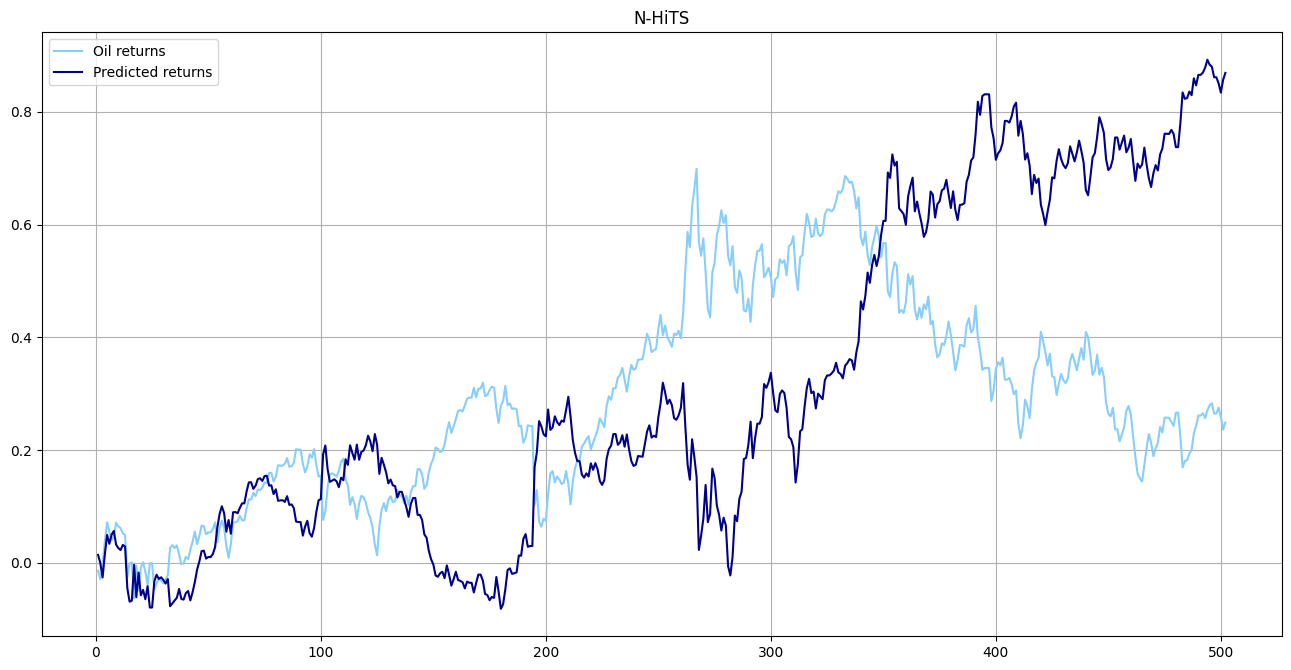

In [719]:

test = pd.read_parquet('oil_best_feats_v3.parquet')
test = test.reset_index()
test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))
test.dropna(inplace=True)

results1 = pd.merge(results, test[['time_idx', 'y', 'Date']], on='time_idx', how='left')


results1.dropna(inplace=True)

results1['Oil_returns'] = results1['y'].shift(-1)
results1['Predicted_returns'] = results1['prediction'].shift(-1)

results1['Signal_predicted'] = np.where(results1['Predicted_returns'] > results1['Predicted_returns'].shift(-1), 1, -1)
results1['Signal_real'] = np.where(results1['Oil_returns'] > results1['Oil_returns'].shift(-1),1, -1)


results1['Strategy_returns'] = results1['Signal_predicted'].shift(1) * results1['Oil_returns']    #preds.signal_preds.shift(1) * preds['preds_returns']
#tor['real_returns'] = tor.signal_real * tor.real_returns
results1.dropna(inplace=True)


results1['Cumulative_real'] = results1['Oil_returns'].cumsum()
results1['Cumulative_strategy'] = results1['Strategy_returns'].cumsum()

plt.figure(figsize=(16,8), dpi= 100, facecolor='w')
plt.grid(True)
plt.plot(results1['Cumulative_real'], color='lightskyblue', label='Oil returns')
plt.plot(results1['Cumulative_strategy'], color='darkblue', label='Predicted returns' )
plt.title('N-HiTS')
plt.legend(loc='best')

In [726]:
#OK
results1 = sharpe_ratio(results1, 'Cumulative_strategy', 504, 0.001)
results1 = sortino_ratio(results1, 'Cumulative_strategy', 504, 0.0001)
results1 = drawdown_ratio(results1, 'Cumulative_strategy')
results1['Avg_daily_returns'] = results1['Strategy_returns'].mean()
results1['St_dev_of_return'] = results1['Strategy_returns'].std()

In [727]:
results1

,time_idx,prediction,y,Date,Oil_returns,Predicted_returns,Signal_predicted,Signal_real,Strategy_returns,Cumulative_real,Cumulative_strategy,sharpe,sharpe_annualized,sortino,sortino_annualized,drawdown,Avg_daily_returns,St_dev_of_return
1,9907,-0.002143,-0.032475,2021-02-26,-0.014082,0.001250,1,1,0.014082,-0.014082,0.014082,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
2,9908,0.001250,-0.014082,2021-03-01,-0.014786,-0.000940,-1,-1,-0.014786,-0.028868,-0.000703,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
3,9909,-0.000940,-0.014786,2021-03-02,0.025284,-0.000138,1,-1,-0.025284,-0.003584,-0.025987,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
4,9910,-0.000138,0.025284,2021-03-03,0.040770,-0.001034,1,1,0.040770,0.037186,0.014782,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
5,9911,-0.001034,0.040770,2021-03-04,0.034794,-0.001054,1,1,0.034794,0.071980,0.049576,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
6,9912,-0.001054,0.034794,2021-03-05,-0.015861,-0.003708,-1,1,-0.015861,0.056119,0.033715,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
7,9913,-0.003708,-0.015861,2021-03-08,-0.016117,0.008440,1,-1,0.016117,0.040002,0.049832,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
8,9914,0.008440,-0.016117,2021-03-09,0.006695,0.001995,-1,-1,0.006695,0.046697,0.056527,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
9,9915,0.001995,0.006695,2021-03-10,0.024223,0.006135,1,1,-0.024223,0.070921,0.032304,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546
10,9916,0.006135,0.024223,2021-03-11,-0.006230,0.001508,1,-1,-0.006230,0.064691,0.026075,1.06195,0.535223,14.590342,0.735353,-0.799329,0.001731,0.026546


In [696]:
# Regression with a constant

X_sm = sm.add_constant(results1)
y = X_sm[['Strategy_returns']]
X = X_sm[['const']]
model_const_nhits = sm.OLS(y, X)
nhits_with_only_const = model_const_nhits.fit()
nhits_with_only_const.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 May 2023   Prob (F-statistic):                nan
Time:                        23:19:31   Log-Likelihood:                 1109.9
No. Observations:                 502   AIC:                            -2218.
Df Residuals:                     501   BIC:                            -2214.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.461      0.145      -0.001       0.004
==============================================================================
Omnibus:                       38.346   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.795
Skew:                           0.007   Prob(JB):                     3.66e-37
Kurtosis:                       5.832   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [697]:
# Regression with marker factors
# Regression

# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])
# test = data[-246:]
# test.reset_index(inplace=True)





results1['Date'] = pd.to_datetime(results1['Date'])
results1_regr_df = pd.merge(results1, ff_regression_df, on='Date', how='left')
results1_regr_df.fillna(0, inplace=True)






In [698]:
# Rgression on market factors
y = results1_regr_df[['Strategy_returns']]
X = results1_regr_df[['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'Oil_returns']]
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
nhits_regr = model.fit() 
nhits_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.913
Date:                Mon, 01 May 2023   Prob (F-statistic):             0.0560
Time:                        23:19:39   Log-Likelihood:                 1117.6
No. Observations:                 502   AIC:                            -2217.
Df Residuals:                     493   BIC:                            -2179.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0017      0.001      1.191      0.234      -0.001       0.004
Mkt-RF           0.0020      0.001      1.801      0.072      -0.000       0.004
SMB             -0.0033      0.002     -1.557      0.120      -0.007       0.001
HML             -0.0001      0.003     -0.049      0.961      -0.005       0.005
RF               0.0032      0.214      0.015      0.988      -0.418       0.425
Mom             -0.0011      0.001     -0.892      0.373      -0.003       0.001
LT_Rev           0.0007      0.003      0.227      0.821      -0.005       0.007
ST_Rev          -0.0006      0.001     -0.440      0.660      -0.003       0.002
Real_returns    -0.1246      0.045     -2.774      0.006      -0.213      -0.036
==============================================================================
Omnibus:                       46.535   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.581
Skew:                          -0.246   Prob(JB):                     1.02e-44
Kurtosis:                       6.073   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [699]:
# Regression on oil factors

# Momentum strategy
test = pd.read_parquet('oil_best_feats_v3.parquet')
test = test.reset_index()
test.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)
test['y'] = np.log(test['y']) - np.log(test['y'].shift(1))

test.dropna(inplace=True)



window = 30
momentum_df =  test[['y' ,'Date']]
#momentum_df['Oil_returns'] = np.log(momentum_df['c1']) - np.log(momentum_df['c1'].shift(1))
momentum_df['Prior_n_real'] = momentum_df['y'].rolling(window).sum()
momentum_df['Position_real_mom'] = [1 if i>0 else -1 for i in momentum_df.Prior_n_real]
momentum_df['Strat_real_mom'] = momentum_df.Position_real_mom.shift(1) * momentum_df["y"]
momentum_df = momentum_df[-results1.shape[0]:]




In [700]:
# carry strategy
carry_df = pd.read_excel("wti_data.xlsx", sheet_name='Close', parse_dates=['Date'])
carry_df.rename(columns={carry_df.columns[1]: 'c1', carry_df.columns[2]:'c2'}, inplace=True)
carry_df = carry_df[['Date','c1', 'c2']]
carry_df['c1'] = np.log(carry_df['c1']) - np.log(carry_df['c1'].shift(1))
carry_df['c2'] = np.log(carry_df['c2']) - np.log(carry_df['c2'].shift(1))
carry_df.dropna(inplace=True)

carry_df['carry'] = np.where((carry_df['c1']<carry_df['c2']), 1, -1)
carry_df['carry'] = carry_df['carry'].shift(1)
carry_df = carry_df[-results1.shape[0]:]




In [ ]:
strategies_df.head()

In [701]:
# Both of them together
strategies_df = pd.merge(momentum_df, carry_df[['Date', 'carry']], on='Date', how='left')
strategies_df['Strat_real_carry'] = strategies_df["y"] * strategies_df["carry"]
# Regression on both of strategies
results1.reset_index(inplace=True, drop=True)
strategies_df.reset_index(inplace=True, drop=True)
y = results1[['Strategy_returns']]
X = strategies_df[['y', 'Strat_real_carry', 'Strat_real_mom']]
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

test_df_cnn_multivariate_regr_mom = model.fit() 

test_df_cnn_multivariate_regr_mom.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Strategy_returns   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5.888
Date:                Mon, 01 May 2023   Prob (F-statistic):           0.000591
Time:                        23:19:46   Log-Likelihood:                 1118.6
No. Observations:                 502   AIC:                            -2229.
Df Residuals:                     498   BIC:                            -2212.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0018      0.001      1.544      0.123      -0.000       0.004
y                   -0.1319      0.044     -2.999      0.003      -0.218      -0.045
Strat_real_carry     0.1153      0.044      2.624      0.009       0.029       0.202
Strat_real_mom       0.0611      0.044      1.390      0.165      -0.025       0.148
==============================================================================
Omnibus:                       54.039   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.911
Skew:                          -0.378   Prob(JB):                     1.77e-48
Kurtosis:                       6.153   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# For loop 
MAX_ENCODER_LENGTH = 14
MAX_PREDICTION_LENGTH = 2
BATCH_SIZE = 64
FEATURE_LIST = [ 'Volume_c1', 'DGS1', 'DGS10',
       'Rig_actual', 'GDP', 'CPIAUCSL', 'Negative_sent', 'Positive_sent',
       'Neutral_sent', 'Compounded']
CATEGORICAL_FEATURES_LIST = []#['Day', 'Month', 'Week']
GROUP_ID_FEATURES = ['Cat']

MODEL_HYPERPARAMS = {
                'learning_rate':0.05,
                'dropout':0.05,       
                'log_interval':10,
                'log_val_interval':1,
                'hidden_size':64,
                #'hidden_continuous_size':32,
                #'reduce_on_plateau_patience':10,
                #'attention_head_size':1

}

TRAINER_HYPERPARAMS = {
    'max_epochs':1, 
}

data = pd.read_csv('oil_best_feats_v2.csv')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data = make_category_type(data, 'Month')
data = make_category_type(data, 'Week')
data = make_category_type(data, 'Day')

data = data.reset_index(drop=True)
data['Cat'] = 'Cat'

test = data[-20:]

lower_bound = len(data)-len(test)
upper_bound = len(data)

results = pd.DataFrame()

for i in range(lower_bound, upper_bound+1):

  data1 = data[:i]
  data1 = data1.reset_index()
  data1.loc[data1.index[i-2:], 'y']=0
  
  first_new = data1[data1['y'] == 0]['time_idx'].min()

  training_cutoff = data1["time_idx"].max() - MAX_PREDICTION_LENGTH

  training_dataset, validation_dataset = split_dataset_nhits(data1, MAX_ENCODER_LENGTH, MAX_PREDICTION_LENGTH, training_cutoff=training_cutoff, first_new=first_new, features=FEATURE_LIST, categorical_features=CATEGORICAL_FEATURES_LIST, group_id_features=GROUP_ID_FEATURES)

  training_dataloader, val_dataloader = create_dataloaders(training_dataset=training_dataset, validation_dataset=validation_dataset, batch_size=BATCH_SIZE)
  model_params, trainer_params = optimize_hyperparams_nhits(train_dataloader=training_dataloader, val_dataloader=val_dataloader, n_epochs=1, n_trials=1,model_epochs=1)

  results = train_model_nhits(training_dataset, model_params, trainer_params, train_dataloader=training_dataloader, val_dataloader=val_dataloader)

  results_nhits = evaluate_results(results=results, test_data=test)

  results_nhits = evaluate_error(results_nhits, 'prediction', 'y')



  

  

  

In [ ]:
results_nhits

# N-BEATS

In [ ]:
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
import pandas as pd
import numpy as np


import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import NHiTS, TimeSeriesDataSet

from pytorch_forecasting.metrics import QuantileLoss, RMSE
from sklego.preprocessing import RepeatingBasisFunction   
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from datetime import datetime
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet


In [ ]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20


data = pd.read_parquet('oil_best_feats_v3.parquet')
data = data.reset_index()
data.rename(columns={'index':'time_idx', 'c1':'y'}, inplace=True)

data = make_category_type(data, 'Month')

#data = make_category_type(data, 'Day')

data = data.reset_index(drop=True)
data['Cat'] = 'Cat'



data['y'] = np.log(data['y']) - np.log(data['y'].shift(1))
data.dropna(inplace=True)
data['y'][-20:] = 0

data1 = data.copy()


training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data1[lambda x: x.time_idx <= training_cutoff],
    group_ids=['Cat'],
    time_idx="time_idx",
    target="y",
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["y"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data1, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
# pl.seed_everything(42)
trainer = pl.Trainer(accelerator="auto", gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


# Cross Validation

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
res_list = []

df = pd.read_csv('oil_best_feats_v2.csv')
df.set_index('Date', inplace=True)
df_mv = df[df.Year>=1985]
sc = MinMaxScaler(feature_range=(0, 1))


for i in range(1990, 2025, 5):

  train_df = df[(df.Year<i)&(df.Year>i-5)]
  test_df = df[df.Year==i]

  train_scaled = sc.fit_transform(train_df)
  test_scaled = sc.fit_transform(test_df)





  X_train, y_train = create_data_train(train_scaled,  n_future=1, n_past=5)
  X_test, y_test = create_data_test(test_scaled,  n_future=1, n_past=5)


  lstm_uni = Sequential()
  early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=10,
                                    mode='min')



  lstm_uni.add(LSTM(512, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), 
                                return_sequences=False))
  lstm_uni.add(Dropout(0.1))
  lstm_uni.add(Dense(y_train.shape[1], activation='relu'))


  lstm_uni.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history_lstm_un = lstm_uni.fit(X_train, y_train, validation_split=0.1 ,epochs=1, batch_size=64, callbacks=[early_stopping])

  lstm_uni.evaluate(X_test, y_test)
  lstm_uni.evaluate(X_train, y_train)

  
  train_rmse = lstm_uni.evaluate(X_train, y_train)[1]
  test_rmse = lstm_uni.evaluate(X_test, y_test)[1]
  res_list.extend([train_rmse,test_rmse])

  print(f'\n for year {i} the error is {train_rmse} train and {test_rmse} test')

  return_prediction(X_test, y_test, X_train, y_train, train_scaled, lstm_uni, 'lstm_uni', 'price')

  
















# Evaluate results

In [ ]:
overall_table = save_rmse()

In [ ]:
overall_table

In [ ]:
cnn_multivariate_df

# Long Short Trading Strategy

In [ ]:
nhits_df = pd.read_parquet('nhits_results_temp.parquet')
transformer_df = pd.read_parquet('transformer_results_temp.parquet')
nhits_df.rename(columns={'prediction':'Predicted_value', 'y':'Real_value'}, inplace=True)
transformer_df.rename(columns={'prediction':'Predicted_value', 'y':'Real_value'}, inplace=True)


In [ ]:
lstm_univariate_inv_strategy = evaluate_inv_strategy(lstm_univariate_df, 'Real_value', 'Predicted_value','price')
plot_strategies(lstm_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

In [ ]:
cnn_multivariate_inv_strategy = evaluate_inv_strategy(cnn_multivariate_df, 'Real_value', 'Predicted_value', 'returns')
lstm_multivariate_inv_strategy = evaluate_inv_strategy(lstm_multivariate_df, 'Real_value', 'Predicted_value','returns')

cnn_univariate_inv_strategy = evaluate_inv_strategy(cnn_univariate_df, 'Real_value', 'Predicted_value','returns')
lstm_univariate_inv_strategy = evaluate_inv_strategy(lstm_univariate_df, 'Real_value', 'Predicted_value','returns')

nhits_df = evaluate_inv_strategy(nhits_df, 'Real_value', 'Predicted_value','prices')
transformer_df = evaluate_inv_strategy(transformer_df, 'Real_value', 'Predicted_value','prices')


In [ ]:
plot_strategies(transformer_df, 'Cumul_real', 'Cumul_strat')

In [ ]:
cnn_multivariate_inv_strategy

In [ ]:
plot_strategies(cnn_multivariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

In [ ]:
plot_strategies(lstm_multivariate_inv_strategy, 'Cumul_real', 'Cumul_strat')
#plot_strategies(cnn_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')
plot_strategies(lstm_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

In [ ]:
plot_strategies(lstm_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

In [ ]:
plot_strategies(cnn_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

In [ ]:
plt.plot(nhits_df.Date, nhits_df.Cumul_real)
plt.plot(nhits_df.Date, nhits_df.Cumul_strat)

In [ ]:

plot_strategies(transformer_df, 'Cumul_real', 'Cumul_strat')

In [ ]:
cnn_multivariate_inv_strategy

In [ ]:
plot_strategies(cnn_multivariate_inv_strategy, 'Cumul_real', 'Cumul_strat')
plot_strategies(lstm_multivariate_inv_strategy, 'Cumul_real', 'Cumul_strat')
plot_strategies(cnn_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')
plot_strategies(lstm_univariate_inv_strategy, 'Cumul_real', 'Cumul_strat')

# Ratios calculation

In [ ]:
cnn_multivariate_inv_strategy1 = sharpe_ratio(cnn_multivariate_inv_strategy, 'strat_return', 252, 0.01)
cnn_multivariate_inv_strategy1 = sortino_ratio(cnn_multivariate_inv_strategy, 'strat_return', 252, 0.01)
cnn_multivariate_inv_strategy1 = drawdown_ratio(cnn_multivariate_inv_strategy, 'strat_return')

lstm_multivariate_inv_strategy1 = sharpe_ratio(lstm_multivariate_inv_strategy, 'strat_return', 252, 0.01)
lstm_multivariate_inv_strategy1 = sortino_ratio(lstm_multivariate_inv_strategy, 'strat_return', 252, 0.01)
lstm_multivariate_inv_strategy1 = drawdown_ratio(lstm_multivariate_inv_strategy, 'strat_return')

cnn_univariate_inv_strategy1 = sharpe_ratio(cnn_univariate_inv_strategy, 'strat_return', 252, 0.01)
cnn_univariate_inv_strategy1 = sortino_ratio(cnn_univariate_inv_strategy, 'strat_return', 252, 0.01)
cnn_univariate_inv_strategy1 = drawdown_ratio(cnn_univariate_inv_strategy, 'strat_return')

lstm_univariate_inv_strategy1 = sharpe_ratio(lstm_univariate_inv_strategy, 'strat_return', 252, 0.01)
lstm_univariate_inv_strategy1 = sortino_ratio(lstm_univariate_inv_strategy, 'strat_return', 252, 0.01)
lstm_univariate_inv_strategy1 = drawdown_ratio(lstm_univariate_inv_strategy, 'strat_return')

nhits_df_inv_strategy_1 = sharpe_ratio(nhits_df, 'strat_return', 252, 0.01)
nhits_df_inv_strategy_1 = sortino_ratio(nhits_df, 'strat_return', 252, 0.01)
nhits_df_inv_strategy_1 = drawdown_ratio(nhits_df, 'strat_return')

transformer_df_inv_strategy_1 = sharpe_ratio(transformer_df, 'strat_return', 252, 0.01)
transformer_df_inv_strategy_1 = sortino_ratio(transformer_df, 'strat_return', 252, 0.01)
transformer_df_inv_strategy_1 = drawdown_ratio(transformer_df, 'strat_return')

In [ ]:
cnn_multivariate_inv_strategy1

In [ ]:
cnn_univariate_inv_strategy1

In [ ]:
lstm_univariate_inv_strategy1

In [ ]:
cnn_multivariate_inv_strategy1

In [ ]:
nhits_df_inv_strategy_1

In [ ]:
transformer_df_inv_strategy_1

# Fama French Regression

In [ ]:


# Fama French Factors
ff_regression_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv')
ff_regression_df['Date'] = ff_regression_df['Date'].astype('str')
ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'], format='%Y %m %d')

momentum = pd.read_csv('F-F_Momentum_Factor_daily.csv')
momentum['Date'] = momentum['Date'].astype('str')
momentum['Date'] = pd.to_datetime(momentum['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

lt_factor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
lt_factor['Date'] = lt_factor['Date'].astype('str')
lt_factor['Date'] = pd.to_datetime(lt_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False), errors='coerce')


st_factor = pd.read_csv('F-F_ST_Reversal_Factor_daily.csv')
st_factor['Date'] = st_factor['Date'].astype('str')
st_factor['Date'] = pd.to_datetime(st_factor['Date'].str.extract(r'^\s*([^\s]+)', expand=False),
                    errors='coerce')

# Merge all dfs
ff_regression_df = pd.merge(ff_regression_df, momentum, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, lt_factor, on='Date', how='left')
ff_regression_df = pd.merge(ff_regression_df, st_factor, on='Date', how='left')

ff_regression_df['Date'] = pd.to_datetime(ff_regression_df['Date'])
# test = data[-246:]
# test.reset_index(inplace=True)



In [ ]:
ff_regression_df.head()

In [ ]:
def prepare_ff_regression(df, regresion_df, test_df, rf):

    df = df[['strat_return', 'real_returns']]

    df['Date'] = test_df['Date']

    test_df['Date'] = pd.to_datetime(test_df['Date'])
    regresion_df['Date'] = pd.to_datetime(regresion_df['Date'])

    df_exogen = pd.merge(test_df[['Date']], regresion_df, on='Date', how='left')

    df_exogen = pd.merge(df_exogen, df, on='Date', how='left')

    df_exogen.dropna(inplace=True)

    df_exogen['real_returns'] = df_exogen['real_returns'] - rf

    return df_exogen

In [ ]:
results1['Date'] = pd.to_datetime(results1['Date'])
results2 = pd.merge(results1, ff_regression_df, on='Date', how='left')
results2.head()

In [ ]:
y = results2[['Strategy_returns']]

X = results2[['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'Oil_returns']]

X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm)

results_regr = model.fit() 

results_regr.summary()


In [ ]:
calculate_ff_regression(results1, 'Strategy_returns', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'Oil_returns'])

In [ ]:
results1.head()

In [ ]:
test.head()

In [ ]:
cnn_multivariate_regression = prepare_ff_regression(cnn_multivariate_inv_strategy1, ff_regression_df, test, 0.05)
cnn_univariate_regression = prepare_ff_regression(cnn_univariate_inv_strategy1, ff_regression_df, test, 0.05)

lstm_multivariate_regression = prepare_ff_regression(lstm_multivariate_inv_strategy1, ff_regression_df, test, 0.05)
lstm_univariate_regression = prepare_ff_regression(lstm_multivariate_inv_strategy1, ff_regression_df, test, 0.05)

nhits_df_regression = prepare_ff_regression(nhits_df_inv_strategy_1, ff_regression_df, test, 0.05)
transformer_df_regression = prepare_ff_regression(transformer_df_inv_strategy_1, ff_regression_df, test, 0.05)

calculate_ff_regression(cnn_multivariate_regression, 'strat_return', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'real_returns'])

In [ ]:
calculate_ff_regression(cnn_univariate_regression, 'strat_return', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'real_returns'])

In [ ]:
calculate_ff_regression(lstm_multivariate_regression, 'strat_return', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'real_returns'])

In [ ]:
calculate_ff_regression(nhits_df_regression, 'strat_return', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'real_returns'])

In [ ]:
calculate_ff_regression(transformer_df_regression, 'strat_return', ['Mkt-RF',	'SMB',	'HML',	'RF',	'Mom   ',	'LT_Rev',	'ST_Rev',	'real_returns'])

# Compare

In [732]:
cg = pd.read_parquet('part-00000-f2436524-33b2-4434-822f-c01411f2f8fd-c000.snappy.parquet')
cg = pd.read_parquet('campaign_2023.parquet')
cg['createdon'].head()

0   2023-02-15
1   2023-02-17
2   2023-01-09
3   2023-01-24
4   2023-01-02
Name: createdon, dtype: datetime64[ns]

In [ ]:
mine = pd.read_csv('export.csv')
anna  = pd.read_excel('Sopkova_chybu_sposobil_filter_new.xlsx')


In [ ]:
df3 = pd.merge(mine, anna, how='outer', indicator='Exist')

In [ ]:
anna[anna.vse_salespersonname=='Katarína Molnár']

In [ ]:
df3

In [ ]:
df3.to_csv('porovnani_view_Sopkova_Chybu_Sposobil.csv')

In [733]:
vc = pd.read_csv('vse_calculatedsaving_2022.csv')
vc.head()

,64ee4f75-7c6c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM.1,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,Unnamed: 8,Unnamed: 9,...,Josef Bezdicka.5,Kalkulované úspory zákazník Iveta Nováková,vse-dev3,# CRM VSE - DEV3.2,Unnamed: 56,# CRM VSE - DEV3.3,66611960,2022-01-03T23:00:00Z,2022-12-24T11:29:11Z.1,Unnamed: 61
0,d665c4b0-816c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,NaN,NaN,...,Josef Bezdicka,Kalkulované úspory zákazník Nadežda Mudráková,vse-dev3,# CRM VSE - DEV3,NaN,# CRM VSE - DEV3,66611964,2022-01-03T23:00:00Z,2022-12-24T11:29:11Z,NaN
1,67ee94c7-7c6c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,NaN,NaN,...,Michaela Burianova,Kalkulované úspory zákazník Ing. Jana Kolejová,vse-dev3,# CRM VSE - DEV3,NaN,# CRM VSE - DEV3,66611965,2021-12-26T23:00:00Z,2022-12-24T11:29:11Z,NaN
2,1bf90262-7d6c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM,0,1,865480000,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,NaN,NaN,...,Viktoria Corosova,Kalkulované úspory zákazník Mária Wild,vse-dev3,# CRM VSE - DEV3,2022-01-04T12:03:46Z,# CRM VSE - DEV3,66611969,2021-12-19T23:00:00Z,2022-12-24T11:29:11Z,NaN
3,221f01c6-7d6c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,NaN,NaN,...,Michaela Burianova,Kalkulované úspory zákazník Viktor Pišta,vse-dev3,# CRM VSE - DEV3,NaN,# CRM VSE - DEV3,66611971,2021-12-22T23:00:00Z,2022-12-24T11:29:11Z,NaN
4,81263a3d-676c-ec11-84dd-005056a1056f,4/10/2023 5:11:59 PM,4/10/2023 5:11:59 PM,0,1,865480000,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,NaN,NaN,...,Miroslava Jurockova,Kalkulované úspory zákazník Mgr. Anna Belovežč...,vse-dev3,# CRM VSE - DEV3,2022-01-04T12:11:36Z,# CRM VSE - DEV3,66611974,2021-11-25T23:00:00Z,2022-12-24T11:29:11Z,NaN


In [734]:
pq = pd.read_parquet('vse_calculatedsaving_2023.parquet')
pq.head()

,Id,SinkCreatedOn,SinkModifiedOn,statecode,statuscode,vse_type,modifiedonbehalfby,modifiedonbehalfby_entitytype,owningteam,owningteam_entitytype,...,createdbyname,vse_name,owningbusinessunitname,createdonbehalfbyname,vse_cashbackdate,modifiedonbehalfbyname,versionnumber,vse_discountusagedate,overriddencreatedon,IsDelete
0,2a46e5fa-748a-ed11-85ae-005056a1056f,2023-04-10,2023-04-10,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,None,None,...,Josef Bezdicka,Kalkulované úspory zákazník Štefan Hamer,vse-dev3,# CRM VSE - DEV3,None,# CRM VSE - DEV3,234959570,2023-01-01,2023-02-21,None
1,05769d52-718a-ed11-85ae-005056a1056f,2023-04-10,2023-04-10,0,1,865480000,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,None,None,...,Anna Sykorova,Kalkulované úspory zákazník Dana Švekušová,vse-dev3,# CRM VSE - DEV3,2023-01-03,# CRM VSE - DEV3,234959573,2023-01-01,2023-02-21,None
2,868be947-708a-ed11-85ae-005056a1056f,2023-04-10,2023-04-10,0,1,865480000,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,None,None,...,Josef Bezdicka,Kalkulované úspory zákazník Ingrid Uhlárová,vse-dev3,# CRM VSE - DEV3,2023-01-03,# CRM VSE - DEV3,234959575,2023-01-01,2023-02-21,None
3,cbe08ff9-6c8a-ed11-85ae-005056a1056f,2023-04-10,2023-04-10,0,1,865480001,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,None,None,...,Natalia Bodnarova,Kalkulované úspory zákazník Mária Paločková,vse-dev3,# CRM VSE - DEV3,None,# CRM VSE - DEV3,234959578,2023-01-01,2023-02-21,None
4,aea33fc4-778a-ed11-85ae-005056a1056f,2023-04-10,2023-04-10,0,1,865480000,06dab2e3-157a-ed11-81ad-0022487fe033,systemuser,None,None,...,Miroslava Dobranska,Kalkulované úspory zákazník Katarína Medvecká,vse-dev3,# CRM VSE - DEV3,2023-01-03,# CRM VSE - DEV3,234959581,2022-12-29,2023-02-21,None
